---

# ATML PA2 - TASK 2: DG via Invariant & Robust Learning

In [ ]:
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import Subset, ConcatDataset, DataLoader
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import torchvision
import torch
import os
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import copy
from torch.autograd import grad

torch.manual_seed(42)
torch.cuda.manual_seed_all(42) 


if not os.path.isdir('./Homework3-PACS'):
    !git clone https://github.com/MachineLearning2020/Homework3-PACS

In [ ]:
means, stds = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

transf = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

DIR_PHOTO = 'Homework3-PACS/PACS/photo'
DIR_ART = 'Homework3-PACS/PACS/art_painting'
DIR_CARTOON = 'Homework3-PACS/PACS/cartoon'
DIR_SKETCH = 'Homework3-PACS/PACS/sketch'

photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO, transform=transf)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART, transform=transf)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON, transform=transf)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH, transform=transf)

domains = {
    'photo': photo_dataset,
    'art_painting': art_dataset,
    'cartoon': cartoon_dataset,
    'sketch': sketch_dataset
}

print("Dataset loaded successfully!")
for name, dataset in domains.items():
    print(f"{name}: {len(dataset)} samples")

source_domains = ['art_painting', 'cartoon', 'photo']
target_domain = 'sketch'

source_datasets = {name: domains[name] for name in source_domains}
target_dataset = domains[target_domain]

print(f"Domain Generalization Setup:")
print(f"   Sources: {', '.join(source_domains)}")
print(f"   Target (unseen): {target_domain}")
print(f"   Target samples: {len(target_dataset)}")


source_train_loaders = {}
source_test_loaders = {}
batch_size = 32

for domain_name in source_domains:
    dataset = source_datasets[domain_name]
    labels = np.array([s[1] for s in dataset.samples])

    train_idx, test_idx = train_test_split(
        np.arange(len(labels)),
        test_size=0.2,
        random_state=42,
        stratify=labels
    )

    train_subset = Subset(dataset, train_idx)
    test_subset = Subset(dataset, test_idx)

    source_train_loaders[domain_name] = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    source_test_loaders[domain_name] = DataLoader(
        test_subset, batch_size=batch_size, shuffle=False
    )

    print(f"   {domain_name}: train={len(train_subset)}, test={len(test_subset)}")

target_test_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=False)



Dataset loaded successfully!
photo: 1670 samples
art_painting: 2048 samples
cartoon: 2344 samples
sketch: 3929 samples
Domain Generalization Setup:
   Sources: art_painting, cartoon, photo
   Target (unseen): sketch
   Target samples: 3929
   art_painting: train=1638, test=410
   cartoon: train=1875, test=469
   photo: train=1336, test=334


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

def create_model():
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
    num_classes = len(art_dataset.classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

def evaluate_model(model, loader, domain_name=""):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

Device: cuda


IRMv1 - SQR NORM

In [ ]:

print("\n" + "Running IRM")
squared_results = run_irm_ablation(
    penalty_weights=[1.0],
    use_variance=False
)


Running IRM

IRM ABLATION STUDY: SquaredNorm Version

Testing λ = 1.0

🚀 Training IRM (SquaredNorm, λ=1.0)...


IRM Epoch 10/10: 100%|██████████| 41/41 [00:15<00:00,  2.60it/s, loss=0.003, nll=0.00255, penalty=0.000455]



📊 IRM Epoch 10 Results:
   art_painting: 90.73%
   cartoon: 91.90%
   photo: 98.20%
   Average Source: 93.61%
   Target (sketch): 63.96%
   Final NLL: 0.0025, Penalty: 0.0005
---losses---
[1.1073740640791452, 0.2719728172552295, 0.1316106987253922, 0.04637186166762215, 0.020475321528842537, 0.010715698244095576, 0.0063747620897185876, 0.005552656171991058, 0.0037516409505681113, 0.0030046710829682104]
---nlls---
[0.9928913792458977, 0.2388938472765248, 0.11055490974246002, 0.03874127979095026, 0.01660118195250994, 0.009116100953755582, 0.005426563720059831, 0.00467778051345859, 0.003202868778849157, 0.0025496726284916626]
---penalties---
[0.11448268559420617, 0.033078969931854614, 0.021055789556490574, 0.007630581430886395, 0.0038741393960308192, 0.0015995973226381466, 0.0009481983359409041, 0.0008748756283638635, 0.0005487721672823947, 0.00045499842963181436]

RESULTS SUMMARY
     λ   Avg Source   Target    Penalty      NLL
------------------------------------------------------------

ERM FINAL

In [ ]:
def train_erm_model(model, source_loaders, criterion, optimizer, epochs=10):
    model.train()
    train_losses = []

    print(" Training ERM...")

    iterators = {}
    for domain in source_domains:
        def make_infinite(loader):
            while True:
                for batch in loader:
                    yield batch
        iterators[domain] = make_infinite(source_loaders[domain])

    steps_per_epoch = min(len(loader) for loader in source_loaders.values())

    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        loop = tqdm(range(steps_per_epoch), desc=f"ERM Epoch {epoch}/{epochs}")

        for step in loop:
            inputs_list = []
            labels_list = []

            for domain in source_domains:
                imgs, labels = next(iterators[domain])
                inputs_list.append(imgs.to(device))
                labels_list.append(labels.to(device))

            inputs = torch.cat(inputs_list, dim=0)
            labels = torch.cat(labels_list, dim=0)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

            loop.set_postfix(loss=epoch_loss/(step+1))

        avg_loss = epoch_loss / steps_per_epoch
        train_losses.append(avg_loss)

        if epoch % 5 == 0 or epoch == epochs:
            print(f"\n ERM Epoch {epoch} Results:")
            source_accs = []
            for domain in source_domains:
                acc = evaluate_model(model, source_test_loaders[domain], domain)
                source_accs.append(acc)
                print(f"   {domain}: {acc:.2f}%")

            target_acc = evaluate_model(model, target_test_loader, target_domain)
            avg_source_acc = np.mean(source_accs)
            print(f"   Average Source: {avg_source_acc:.2f}%")
            print(f"   Target ({target_domain}): {target_acc:.2f}%")
            print(f"   Loss: {avg_loss:.4f}")

    return train_losses, source_accs, target_acc

erm_model = create_model()
erm_criterion = nn.CrossEntropyLoss()
erm_optimizer = optim.Adam(erm_model.parameters(), lr=1e-4, weight_decay=1e-4)  # Same as IRM

erm_losses, erm_source_accs, erm_target_acc = train_erm_model(
    erm_model, source_train_loaders, erm_criterion, erm_optimizer, epochs=10
)



🧠 Training ERM...


ERM Epoch 5/10: 100%|██████████| 41/41 [00:17<00:00,  2.31it/s, loss=0.00546]



📊 ERM Epoch 5 Results:
   art_painting: 93.17%
   cartoon: 95.52%
   photo: 98.50%
   Average Source: 95.73%
   Target (sketch): 60.17%
   Loss: 0.0055


ERM Epoch 10/10: 100%|██████████| 41/41 [00:17<00:00,  2.33it/s, loss=8.27e-6]



📊 ERM Epoch 10 Results:
   art_painting: 91.95%
   cartoon: 95.74%
   photo: 98.20%
   Average Source: 95.30%
   Target (sketch): 61.59%
   Loss: 0.0000


In [ ]:
torch.save(erm_model.state_dict(), "erm_model.pth")

In [19]:
# ERM results
erm_source_accs = [91.95, 95.74, 98.20]
erm_target_acc = 61.59
erm_loss = 0.0000

# IRM results
irm_source_accs = [90.73, 91.90, 98.20]
irm_target_acc = 63.96
irm_final_nll = 0.0025
irm_final_penalty = 0.0005

irm_losses = [
    1.1073740640791452, 0.2719728172552295, 0.1316106987253922, 0.04637186166762215,
    0.020475321528842537, 0.010715698244095576, 0.0063747620897185876, 0.005552656171991058,
    0.0037516409505681113, 0.0030046710829682104
]

irm_nll = [
    0.9928913792458977, 0.2388938472765248, 0.11055490974246002, 0.03874127979095026,
    0.01660118195250994, 0.009116100953755582, 0.005426563720059831, 0.00467778051345859,
    0.003202868778849157, 0.0025496726284916626
]

irm_penalties = [
    0.11448268559420617, 0.033078969931854614, 0.021055789556490574, 0.007630581430886395,
    0.0038741393960308192, 0.0015995973226381466, 0.0009481983359409041, 0.0008748756283638635,
    0.0005487721672823947, 0.00045499842963181436
]



FINAL RESULTS

IRM Results:
Source art_painting: 90.73%
Source cartoon     : 91.90%
Source photo       : 98.20%
Average Source     : 93.61%
Target sketch    : 63.96%
Generalization Gap : 29.65%
Final IRM Penalty  : 0.0005

ERM Results:
Source art_painting: 91.95%
Source cartoon     : 95.74%
Source photo       : 98.20%
Average Source     : 95.30%
Target sketch    : 61.59%
Generalization Gap : 33.71%

IRM vs ERM Comparison:
   Target Improvement: +2.37%
   Source Trade-off: -1.69%


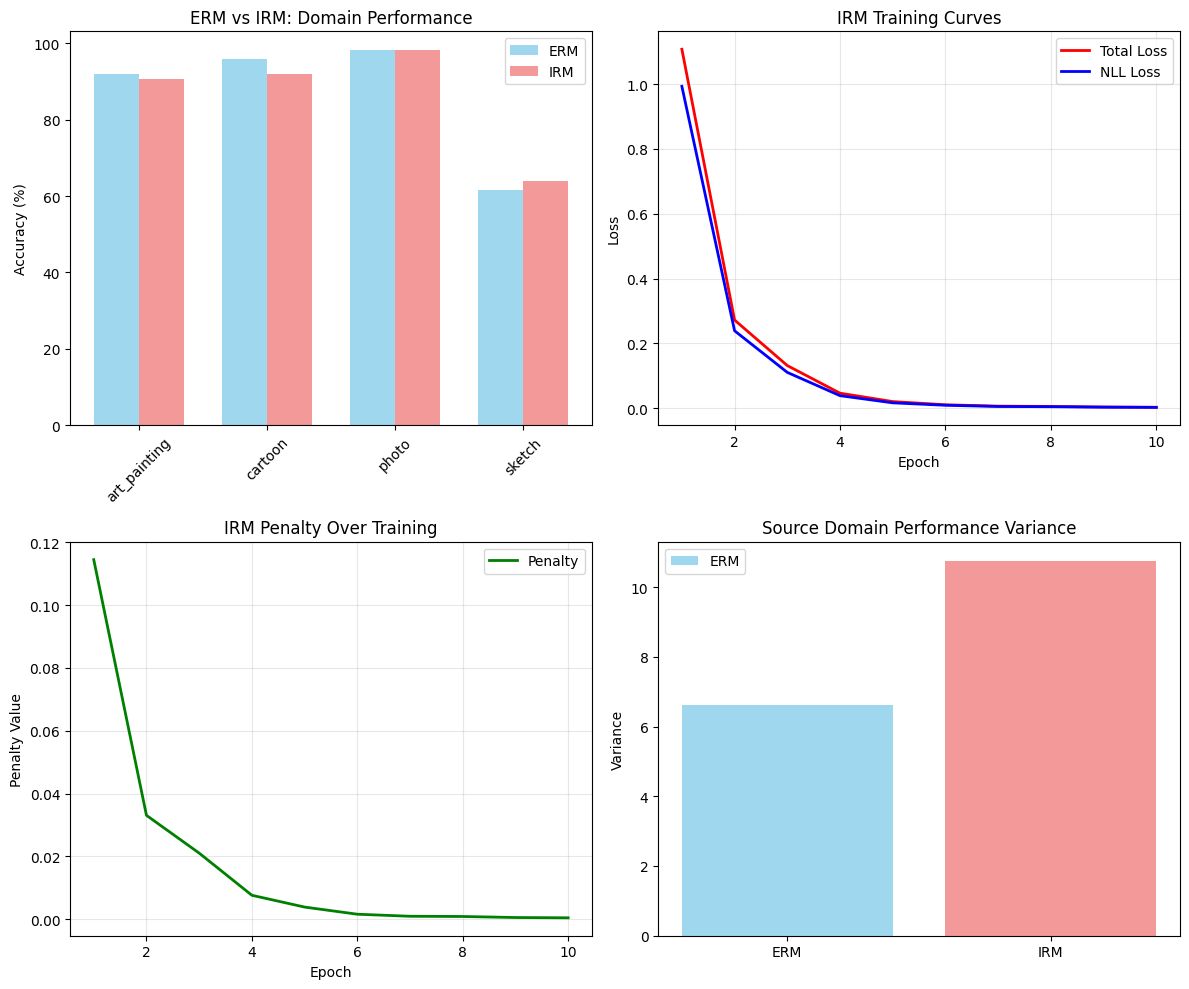

In [ ]:
domains_list = source_domains + [target_domain]

erm_results = {domain: acc for domain, acc in zip(source_domains, erm_source_accs)}
erm_results[target_domain] = erm_target_acc
irm_results = {domain: acc for domain, acc in zip(source_domains, irm_source_accs)}
irm_results[target_domain] = irm_target_acc

erm_avg_source = np.mean(erm_source_accs)
irm_avg_source = np.mean(irm_source_accs)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

print("\nIRM Results:")
for domain in source_domains:
    print(f"Source {domain:12s}: {irm_results[domain]:.2f}%")
print(f"Average Source     : {irm_avg_source:.2f}%")
print(f"Target {target_domain:10s}: {irm_target_acc:.2f}%")
print(f"Generalization Gap : {irm_avg_source - irm_target_acc:.2f}%")
print(f"Final IRM Penalty  : {irm_penalties[-1]:.4f}")

print("\nERM Results:")
for domain in source_domains:
    print(f"Source {domain:12s}: {erm_results[domain]:.2f}%")
print(f"Average Source     : {erm_avg_source:.2f}%")
print(f"Target {target_domain:10s}: {erm_target_acc:.2f}%")
print(f"Generalization Gap : {erm_avg_source - erm_target_acc:.2f}%")

print(f"\nIRM vs ERM Comparison:")
print(f"   Target Improvement: {irm_target_acc - erm_target_acc:+.2f}%")
print(f"   Source Trade-off: {irm_avg_source - erm_avg_source:+.2f}%")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

x = np.arange(len(domains_list))
width = 0.35
erm_vals = [erm_results[d] for d in domains_list]
irm_vals = [irm_results[d] for d in domains_list]
ax1.bar(x - width/2, erm_vals, width, label='ERM', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, irm_vals, width, label='IRM', alpha=0.8, color='lightcoral')
ax1.set_title('ERM vs IRM: Domain Performance')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xticks(x)
ax1.set_xticklabels(domains_list, rotation=45)
ax1.legend()

ax2.plot(range(1, len(irm_losses) + 1), irm_losses, 'r-', label='Total Loss', linewidth=2)
ax2.plot(range(1, len(irm_nll) + 1), irm_nll, 'b-', label='NLL Loss', linewidth=2)
ax2.set_title('IRM Training Curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3.plot(range(1, len(irm_penalties) + 1), irm_penalties, 'g-', label='Penalty', linewidth=2)
ax3.set_title('IRM Penalty Over Training')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Penalty Value')
ax3.legend()
ax3.grid(True, alpha=0.3)

erm_source_var = np.var(erm_source_accs)
irm_source_var = np.var(irm_source_accs)
ax4.bar(['ERM', 'IRM'], [erm_source_var, irm_source_var],
        color=['skyblue', 'lightcoral'], alpha=0.8)
ax4.set_title('Source Domain Performance Variance')
ax4.set_ylabel('Variance')
ax4.legend(['ERM', 'IRM'])

plt.tight_layout()
plt.show()

Table 1: Accuracy (%) of different algorithms on the Colored MNIST synthetic task. ERM
fails in the test environment because it relies on spurious color correlations to classify digits.
IRM detects that the color has a spurious correlation with the label and thus uses only the
digit to predict, obtaining better generalization to the new unseen test environment

CITE THE IRM PAPER IT CONFIRMS OUR RESULTS TOO

---

t-SNE Visualizations

In [ ]:
#first we need to recall the irm model
def create_model():
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
    num_classes = len(art_dataset.classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

irm_model = create_model()
irm_model.load_state_dict(torch.load("irm_model_1.pth", map_location=device))
irm_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in target_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = irm_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

target_acc = 100 * correct / total
print(f"IRM Target (Sketch) Accuracy: {target_acc:.2f}% ({correct}/{total})")

t-SNE ANALYSIS FOR DOMAIN GENERALIZATION

t-SNE ANALYSIS: Testing for Spurious Correlations

📊 Extracting features from ERM model...
   Extracted 896 samples from ERM

📊 Extracting features from IRM model...
   Extracted 896 samples from IRM

📈 Computing domain separation metrics...

🔍 SPURIOUS CORRELATION ANALYSIS:
--------------------------------------------------------------------------------
ERM Metrics:
   Domain Silhouette: 0.0471
   Class Silhouette:  0.3097
   Domain Sep Ratio:  0.3942
   ⚠️  High domain silhouette indicates spurious correlations!

IRM Metrics:
   Domain Silhouette: 0.0183
   Class Silhouette:  0.2980
   Domain Sep Ratio:  0.3523
    Lower domain silhouette means less spurious correlation!

📊 Interpretation:
   IRM reduced domain clustering by 0.0288
   This suggests IRM learned more invariant features

Running t-SNE (this may take a minute)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



 Creating visualizations...


/tmp/ipython-input-3947204000.py:239: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  class_cmap = plt.cm.get_cmap('tab10')


   Saved: tsne_erm_vs_irm_analysis.png


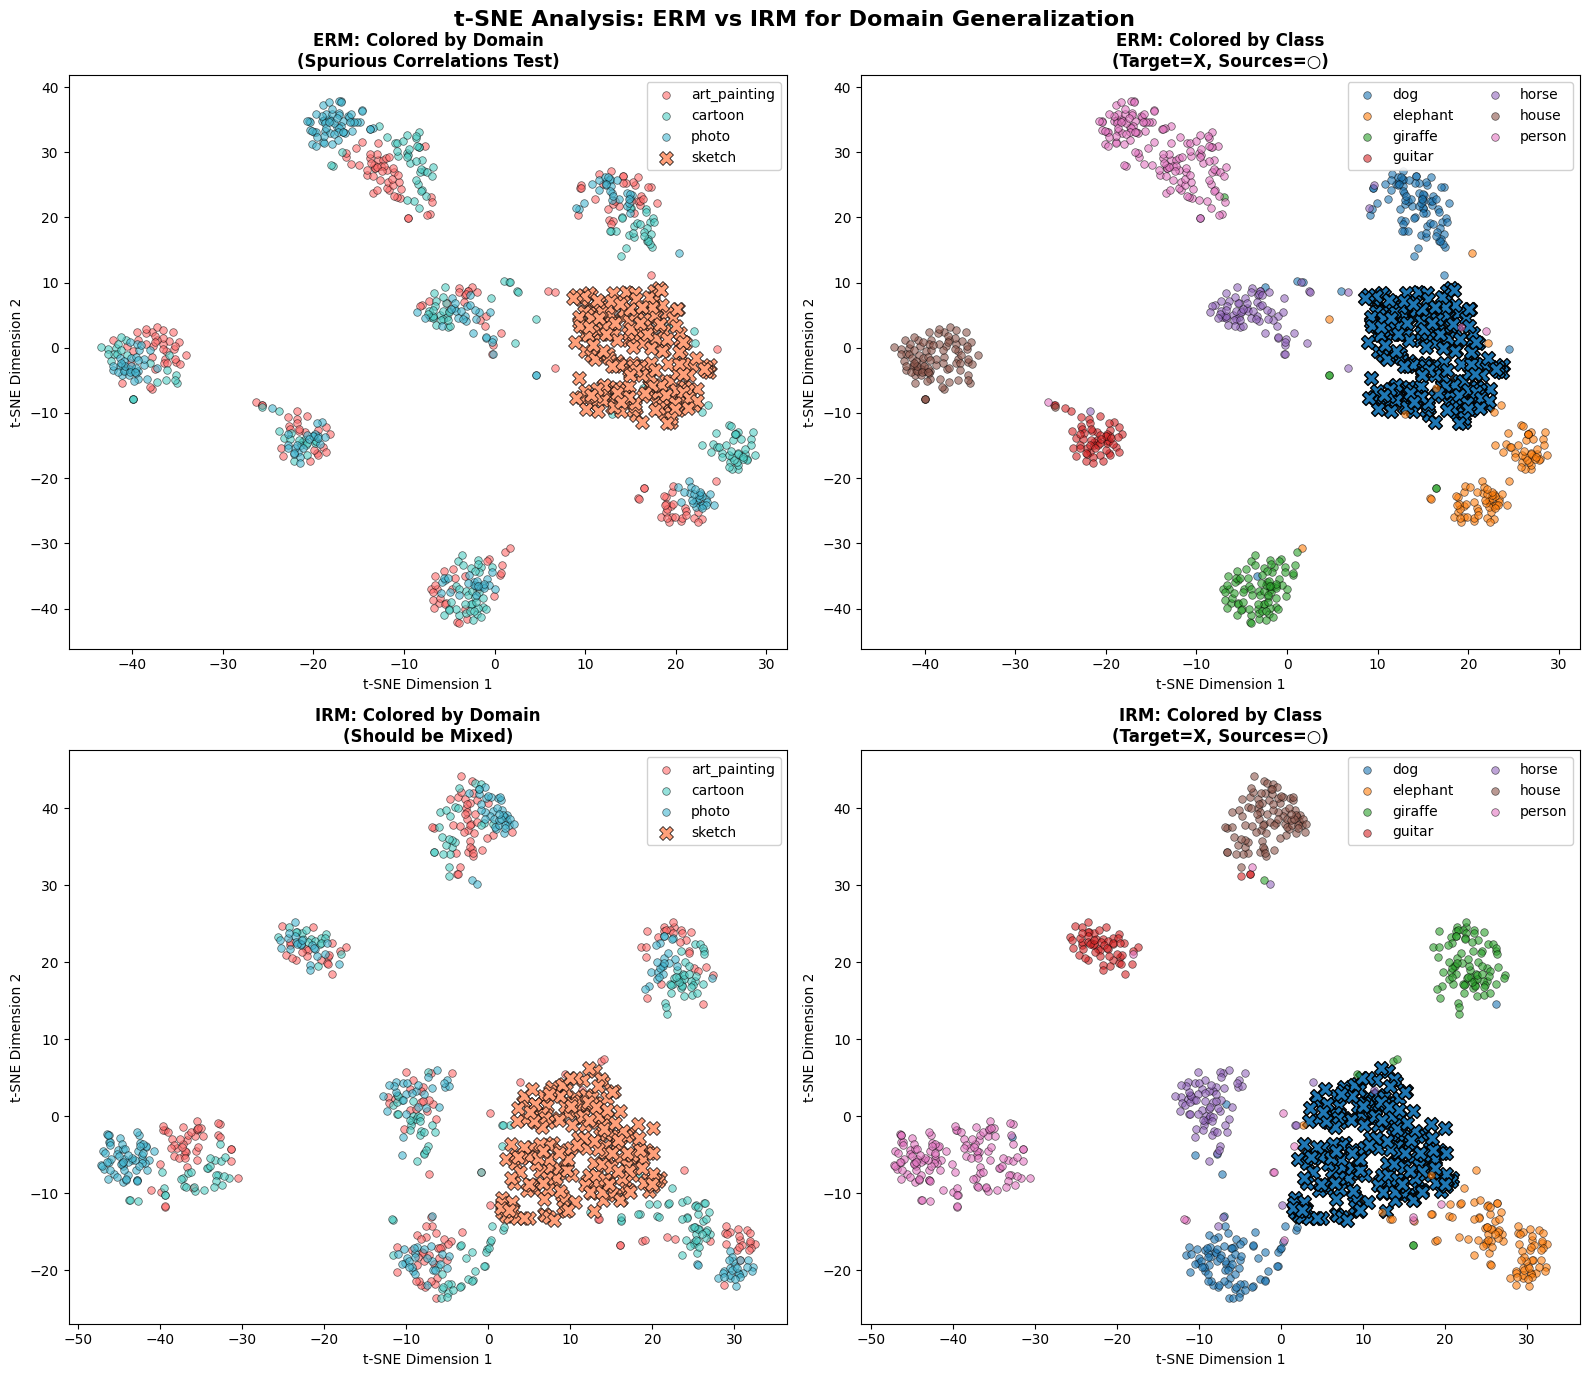


🎯 Target Domain Alignment Analysis:
--------------------------------------------------------------------------------
ERM - Average distance (target to sources): 47.6121
IRM - Average distance (target to sources): 24.1770
IRM reduced target-source distance by 23.4352
This indicates better domain alignment!

SUMMARY: Spurious Correlation Evidence

1. Domain Clustering (Lower is Better):
   ERM: 0.0471
   IRM: 0.0183
   IRM BETTER

2. Class Clustering (Higher is Better):
   ERM: 0.3097
   IRM: 0.2980
   ERM BETTER

3. Target-Source Alignment (Lower is Better):
   ERM: 47.6121
   IRM: 24.1770
   IRM BETTER



In [ ]:
def extract_features(model, loader, domain_name, max_samples=1000):
    
    model.eval()
    features_list = []
    labels_list = []
    domain_labels = []

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    if hasattr(model, 'fc'):
        handle = model.avgpool.register_forward_hook(get_activation('features'))
    elif hasattr(model, 'classifier'):
        handle = model.features.register_forward_hook(get_activation('features'))
    else:
        raise ValueError("Model architecture not recognized")

    samples_collected = 0
    with torch.no_grad():
        for imgs, labels in loader:
            if samples_collected >= max_samples:
                break

            imgs = imgs.to(device)
            _ = model(imgs)  

            feats = activation['features']
            if len(feats.shape) > 2:
                feats = feats.view(feats.size(0), -1)

            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())
            domain_labels.extend([domain_name] * len(labels))

            samples_collected += len(labels)

    handle.remove()

    features = np.vstack(features_list)
    labels = np.concatenate(labels_list)

    return features, labels, domain_labels


def compute_domain_separation_metrics(features, domain_labels, class_labels):
    
    unique_domains = sorted(set(domain_labels))
    domain_to_int = {d: i for i, d in enumerate(unique_domains)}
    domain_ints = np.array([domain_to_int[d] for d in domain_labels])

    domain_silhouette = silhouette_score(features, domain_ints, metric='euclidean')
    class_silhouette = silhouette_score(features, class_labels, metric='euclidean')

    centroids_by_domain = {}
    for domain in unique_domains:
        mask = np.array(domain_labels) == domain
        centroids_by_domain[domain] = features[mask].mean(axis=0, keepdims=True)

    domain_centroids = np.vstack(list(centroids_by_domain.values()))
    inter_domain_dist = cdist(domain_centroids, domain_centroids).mean()

    intra_domain_dists = []
    for domain in unique_domains:
        mask = np.array(domain_labels) == domain
        domain_feats = features[mask]
        centroid = centroids_by_domain[domain]
        dist = cdist(domain_feats, centroid).mean()
        intra_domain_dists.append(dist)
    intra_domain_dist = np.mean(intra_domain_dists)

    return {
        'domain_silhouette': domain_silhouette,
        'class_silhouette': class_silhouette,
        'inter_domain_distance': inter_domain_dist,
        'intra_domain_distance': intra_domain_dist,
        'domain_separation_ratio': inter_domain_dist / (intra_domain_dist + 1e-8)
    }


def perform_tsne_analysis(erm_model, irm_model, source_loaders, target_loader,
                         source_domains, target_domain, max_samples=800,
                         save_plots=True):
    
    print("=" * 80)
    print("t-SNE ANALYSIS: Testing for Spurious Correlations")
    print("=" * 80)

    class_names = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

    # =========================================================================
    
    print("\n Extracting features from ERM model...")
    erm_features_all = []
    erm_labels_all = []
    erm_domains_all = []

    for domain in source_domains:
        feats, labels, domains = extract_features(
            erm_model, source_loaders[domain], domain, max_samples=max_samples//4
        )
        erm_features_all.append(feats)
        erm_labels_all.append(labels)
        erm_domains_all.extend(domains)

    feats, labels, domains = extract_features(
        erm_model, target_loader, target_domain, max_samples=max_samples//4
    )
    erm_features_all.append(feats)
    erm_labels_all.append(labels)
    erm_domains_all.extend(domains)

    erm_features = np.vstack(erm_features_all)
    erm_labels = np.concatenate(erm_labels_all)

    print(f"   Extracted {len(erm_features)} samples from ERM")

    print("\n Extracting features from IRM model...")
    irm_features_all = []
    irm_labels_all = []
    irm_domains_all = []

    for domain in source_domains:
        feats, labels, domains = extract_features(
            irm_model, source_loaders[domain], domain, max_samples=max_samples//4
        )
        irm_features_all.append(feats)
        irm_labels_all.append(labels)
        irm_domains_all.extend(domains)

    feats, labels, domains = extract_features(
        irm_model, target_loader, target_domain, max_samples=max_samples//4
    )
    irm_features_all.append(feats)
    irm_labels_all.append(labels)
    irm_domains_all.extend(domains)

    irm_features = np.vstack(irm_features_all)
    irm_labels = np.concatenate(irm_labels_all)

    print(f"   Extracted {len(irm_features)} samples from IRM")

    # =========================================================================
   
    print("\n Computing domain separation metrics...")

    erm_metrics = compute_domain_separation_metrics(
        erm_features, erm_domains_all, erm_labels
    )
    irm_metrics = compute_domain_separation_metrics(
        irm_features, irm_domains_all, irm_labels
    )

    print("\n SPURIOUS CORRELATION ANALYSIS:")
    print("-" * 80)
    print("ERM Metrics:")
    print(f"   Domain Silhouette: {erm_metrics['domain_silhouette']:.4f}")
    print(f"   Class Silhouette:  {erm_metrics['class_silhouette']:.4f}")
    print(f"   Domain Sep Ratio:  {erm_metrics['domain_separation_ratio']:.4f}")
    print(f"     High domain silhouette indicates spurious correlations!")

    print("\nIRM Metrics:")
    print(f"   Domain Silhouette: {irm_metrics['domain_silhouette']:.4f}")
    print(f"   Class Silhouette:  {irm_metrics['class_silhouette']:.4f}")
    print(f"   Domain Sep Ratio:  {irm_metrics['domain_separation_ratio']:.4f}")
    print(f"    Lower domain silhouette means less spurious correlation!")

    print("\n Interpretation:")
    if erm_metrics['domain_silhouette'] > irm_metrics['domain_silhouette']:
        improvement = (erm_metrics['domain_silhouette'] - irm_metrics['domain_silhouette'])
        print(f"   IRM reduced domain clustering by {improvement:.4f}")
        print(f"   This suggests IRM learned more invariant features")
    else:
        print(f"    IRM did not reduce domain clustering")
        print(f"    This may indicate optimization issues or trivial solutions")

    if irm_metrics['class_silhouette'] > erm_metrics['class_silhouette']:
        print(f"   IRM improved class-based clustering")

    # ==========================
    
    print("\nRunning t-SNE (this may take a minute)...")

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    erm_tsne = tsne.fit_transform(erm_features)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    irm_tsne = tsne.fit_transform(irm_features)

    # ============================

    print("\n Creating visualizations...")

    domain_colors = {'art_painting': '#FF6B6B', 'cartoon': '#4ECDC4',
                     'photo': '#45B7D1', 'sketch': '#FFA07A'}
    class_cmap = plt.cm.get_cmap('tab10')

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle('t-SNE Analysis: ERM vs IRM for Domain Generalization',
                 fontsize=16, fontweight='bold')

    
    ax = axes[0, 0]
    for domain in list(domain_colors.keys()):
        mask = np.array(erm_domains_all) == domain
        marker = 'o' if domain != target_domain else 'X'
        size = 30 if domain != target_domain else 100
        alpha = 0.6 if domain != target_domain else 1.0
        ax.scatter(erm_tsne[mask, 0], erm_tsne[mask, 1],
                  c=domain_colors[domain], label=domain,
                  marker=marker, s=size, alpha=alpha, edgecolors='black', linewidth=0.5)
    ax.set_title('ERM: Colored by Domain\n(Spurious Correlations Test)', fontweight='bold')
    ax.legend(loc='best', framealpha=0.9)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')

    
    ax = axes[0, 1]
    for class_idx in range(len(class_names)):
        mask = erm_labels == class_idx
        
        is_target = np.array(erm_domains_all) == target_domain
        source_mask = mask & ~is_target
        target_mask = mask & is_target

        if source_mask.any():
            ax.scatter(erm_tsne[source_mask, 0], erm_tsne[source_mask, 1],
                      c=[class_cmap(class_idx)], label=class_names[class_idx],
                      marker='o', s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
        if target_mask.any():
            ax.scatter(erm_tsne[target_mask, 0], erm_tsne[target_mask, 1],
                      c=[class_cmap(class_idx)], marker='X', s=100,
                      alpha=1.0, edgecolors='black', linewidth=1.0)
    ax.set_title('ERM: Colored by Class\n(Target=X, Sources=○)', fontweight='bold')
    ax.legend(loc='best', framealpha=0.9, ncol=2)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')

    
    ax = axes[1, 0]
    for domain in list(domain_colors.keys()):
        mask = np.array(irm_domains_all) == domain
        marker = 'o' if domain != target_domain else 'X'
        size = 30 if domain != target_domain else 100
        alpha = 0.6 if domain != target_domain else 1.0
        ax.scatter(irm_tsne[mask, 0], irm_tsne[mask, 1],
                  c=domain_colors[domain], label=domain,
                  marker=marker, s=size, alpha=alpha, edgecolors='black', linewidth=0.5)
    ax.set_title('IRM: Colored by Domain\n(Should be Mixed)', fontweight='bold')
    ax.legend(loc='best', framealpha=0.9)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')

   
    ax = axes[1, 1]
    for class_idx in range(len(class_names)):
        mask = irm_labels == class_idx
        is_target = np.array(irm_domains_all) == target_domain
        source_mask = mask & ~is_target
        target_mask = mask & is_target

        if source_mask.any():
            ax.scatter(irm_tsne[source_mask, 0], irm_tsne[source_mask, 1],
                      c=[class_cmap(class_idx)], label=class_names[class_idx],
                      marker='o', s=30, alpha=0.6, edgecolors='black', linewidth=0.5)
        if target_mask.any():
            ax.scatter(irm_tsne[target_mask, 0], irm_tsne[target_mask, 1],
                      c=[class_cmap(class_idx)], marker='X', s=100,
                      alpha=1.0, edgecolors='black', linewidth=1.0)
    ax.set_title('IRM: Colored by Class\n(Target=X, Sources=○)', fontweight='bold')
    ax.legend(loc='best', framealpha=0.9, ncol=2)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')

    plt.tight_layout()

    if save_plots:
        plt.savefig('tsne_erm_vs_irm_analysis.png', dpi=300, bbox_inches='tight')
        print("   Saved: tsne_erm_vs_irm_analysis.png")

    plt.show()

    # ===========================


    # Compute average distance from target samples to source samples
    erm_target_mask = np.array(erm_domains_all) == target_domain
    erm_source_mask = ~erm_target_mask

    irm_target_mask = np.array(irm_domains_all) == target_domain
    irm_source_mask = ~irm_target_mask

    erm_target_to_source_dist = cdist(
        erm_features[erm_target_mask],
        erm_features[erm_source_mask]
    ).mean()

    irm_target_to_source_dist = cdist(
        irm_features[irm_target_mask],
        irm_features[irm_source_mask]
    ).mean()

    print(f"ERM - Average distance (target to sources): {erm_target_to_source_dist:.4f}")
    print(f"IRM - Average distance (target to sources): {irm_target_to_source_dist:.4f}")

    if irm_target_to_source_dist < erm_target_to_source_dist:
        print(f"IRM reduced target-source distance by {erm_target_to_source_dist - irm_target_to_source_dist:.4f}")
        print("This indicates better domain alignment!")
    else:
        print(" IRM did not improve domain alignment")

    # ========================
    print("\n" + "=" * 80)
    print("SUMMARY: Spurious Correlation Evidence")
    print("=" * 80)

    print("\n1. Domain Clustering (Lower is Better):")
    print(f"   ERM: {erm_metrics['domain_silhouette']:.4f}")
    print(f"   IRM: {irm_metrics['domain_silhouette']:.4f}")
    print(f"   {'IRM BETTER' if irm_metrics['domain_silhouette'] < erm_metrics['domain_silhouette'] else 'ERM BETTER'}")

    print("\n2. Class Clustering (Higher is Better):")
    print(f"   ERM: {erm_metrics['class_silhouette']:.4f}")
    print(f"   IRM: {irm_metrics['class_silhouette']:.4f}")
    print(f"   {'IRM BETTER' if irm_metrics['class_silhouette'] > erm_metrics['class_silhouette'] else 'ERM BETTER'}")

    print("\n3. Target-Source Alignment (Lower is Better):")
    print(f"   ERM: {erm_target_to_source_dist:.4f}")
    print(f"   IRM: {irm_target_to_source_dist:.4f}")
    print(f"   {'IRM BETTER' if irm_target_to_source_dist < erm_target_to_source_dist else 'ERM BETTER'}")

    print("\n" + "=" * 80)

    return {
        'erm_metrics': erm_metrics,
        'irm_metrics': irm_metrics,
        'erm_tsne': erm_tsne,
        'irm_tsne': irm_tsne,
        'erm_target_dist': erm_target_to_source_dist,
        'irm_target_dist': irm_target_to_source_dist
    }


# =============================

results = perform_tsne_analysis(
    erm_model=erm_model,
    irm_model=irm_model,
    source_loaders=source_test_loaders,  
    target_loader=target_test_loader,
    source_domains=source_domains,
    target_domain=target_domain,
    max_samples=800, 
    save_plots=True
)

---

Reloading of original models

In [ ]:
def create_model():
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
    num_classes = len(art_dataset.classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

erm_model = create_model()
erm_model.load_state_dict(torch.load("erm_model.pth", map_location=device))
erm_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in target_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = erm_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

target_acc = 100 * correct / total
print(f"ERM Target (Sketch) Accuracy: {target_acc:.2f}% ({correct}/{total})")

ERM Target (Sketch) Accuracy: 61.59% (2420/3929)


In [ ]:
def create_model():
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
    num_classes = len(art_dataset.classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

irm_model = create_model()
irm_model.load_state_dict(torch.load("irm_model_1.pth", map_location=device))
irm_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in target_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = irm_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

target_acc = 100 * correct / total
print(f"IRM Target (Sketch) Accuracy: {target_acc:.2f}% ({correct}/{total})")

IRM Target (Sketch) Accuracy: 63.96% (2513/3929)


---

GROUP DRO (DISTRIBUTIONALLY ROBUST OPTIMIZATION)


STARTING GROUP DRO TRAINING
---Training Group DRO (Worst-Case Optimization)---
   Group weight step size: 0.01
   Using early stopping (patience=5)


DRO Epoch 1/10: 100%|██████████| 41/41 [00:16<00:00,  2.55it/s, loss=0.613, weights=[0.349, 0.343, 0.308], worst_loss=0.725]



 Group DRO Epoch 1 Results:
   art_painting: 88.54% (weight: 0.3490, loss: 0.7254)
   cartoon: 83.58% (weight: 0.3433, loss: 0.6853)
   photo: 96.71% (weight: 0.3076, loss: 0.4174)
   Average Source: 89.61%
   Worst Source: 83.58%
   Target (sketch): 59.25%
   Weighted Loss: 0.6130
   Group Weights: [0.34902722 0.3433427  0.30763006]
   New best worst-case accuracy: 83.58%


DRO Epoch 2/10: 100%|██████████| 41/41 [00:16<00:00,  2.55it/s, loss=0.169, weights=[0.355, 0.347, 0.298], worst_loss=0.21]



 Group DRO Epoch 2 Results:
   art_painting: 82.20% (weight: 0.3549, loss: 0.2096)
   cartoon: 87.85% (weight: 0.3474, loss: 0.1976)
   photo: 94.31% (weight: 0.2976, loss: 0.0880)
   Average Source: 88.12%
   Worst Source: 82.20%
   Target (sketch): 55.10%
   Weighted Loss: 0.1686
   Group Weights: [0.35493308 0.34744105 0.29762593]
   Patience: 1/5


DRO Epoch 3/10: 100%|██████████| 41/41 [00:15<00:00,  2.60it/s, loss=0.115, weights=[0.359, 0.351, 0.290], worst_loss=0.143]



 Group DRO Epoch 3 Results:
   art_painting: 85.37% (weight: 0.3588, loss: 0.1416)
   cartoon: 92.54% (weight: 0.3514, loss: 0.1429)
   photo: 93.11% (weight: 0.2898, loss: 0.0507)
   Average Source: 90.34%
   Worst Source: 85.37%
   Target (sketch): 57.80%
   Weighted Loss: 0.1153
   Group Weights: [0.35877028 0.35139063 0.28983912]
   New best worst-case accuracy: 85.37%


DRO Epoch 4/10: 100%|██████████| 41/41 [00:15<00:00,  2.57it/s, loss=0.0915, weights=[0.366, 0.351, 0.283], worst_loss=0.138]



 Group DRO Epoch 4 Results:
   art_painting: 90.49% (weight: 0.3657, loss: 0.1382)
   cartoon: 92.96% (weight: 0.3510, loss: 0.0885)
   photo: 97.31% (weight: 0.2833, loss: 0.0363)
   Average Source: 93.59%
   Worst Source: 90.49%
   Target (sketch): 70.96%
   Weighted Loss: 0.0915
   Group Weights: [0.365697   0.35096022 0.2833428 ]
   New best worst-case accuracy: 90.49%


DRO Epoch 5/10: 100%|██████████| 41/41 [00:15<00:00,  2.59it/s, loss=0.0474, weights=[0.369, 0.352, 0.279], worst_loss=0.0697]



 Group DRO Epoch 5 Results:
   art_painting: 90.24% (weight: 0.3691, loss: 0.0697)
   cartoon: 93.60% (weight: 0.3517, loss: 0.0524)
   photo: 95.81% (weight: 0.2793, loss: 0.0119)
   Average Source: 93.22%
   Worst Source: 90.24%
   Target (sketch): 61.92%
   Weighted Loss: 0.0474
   Group Weights: [0.36905515 0.35168788 0.27925694]
   Patience: 1/5


DRO Epoch 6/10: 100%|██████████| 41/41 [00:15<00:00,  2.61it/s, loss=0.0521, weights=[0.370, 0.355, 0.275], worst_loss=0.0731]



 Group DRO Epoch 6 Results:
   art_painting: 89.76% (weight: 0.3699, loss: 0.0577)
   cartoon: 91.47% (weight: 0.3547, loss: 0.0731)
   photo: 96.71% (weight: 0.2754, loss: 0.0181)
   Average Source: 92.64%
   Worst Source: 89.76%
   Target (sketch): 58.79%
   Weighted Loss: 0.0521
   Group Weights: [0.3698935  0.35472596 0.27538055]
   Patience: 2/5


DRO Epoch 7/10: 100%|██████████| 41/41 [00:15<00:00,  2.57it/s, loss=0.0321, weights=[0.372, 0.354, 0.274], worst_loss=0.0446]



 Group DRO Epoch 7 Results:
   art_painting: 91.22% (weight: 0.3718, loss: 0.0446)
   cartoon: 93.60% (weight: 0.3538, loss: 0.0259)
   photo: 97.90% (weight: 0.2744, loss: 0.0232)
   Average Source: 94.24%
   Worst Source: 91.22%
   Target (sketch): 71.90%
   Weighted Loss: 0.0321
   Group Weights: [0.37179816 0.35382396 0.27437788]
   New best worst-case accuracy: 91.22%


DRO Epoch 8/10: 100%|██████████| 41/41 [00:15<00:00,  2.59it/s, loss=0.0316, weights=[0.373, 0.354, 0.273], worst_loss=0.0365]



 Group DRO Epoch 8 Results:
   art_painting: 89.27% (weight: 0.3725, loss: 0.0365)
   cartoon: 94.03% (weight: 0.3544, loss: 0.0355)
   photo: 96.11% (weight: 0.2731, loss: 0.0199)
   Average Source: 93.14%
   Worst Source: 89.27%
   Target (sketch): 68.01%
   Weighted Loss: 0.0316
   Group Weights: [0.3725468  0.35439137 0.27306193]
   Patience: 1/5


DRO Epoch 9/10: 100%|██████████| 41/41 [00:16<00:00,  2.56it/s, loss=0.0164, weights=[0.373, 0.355, 0.272], worst_loss=0.0205]



 Group DRO Epoch 9 Results:
   art_painting: 87.80% (weight: 0.3732, loss: 0.0205)
   cartoon: 91.68% (weight: 0.3547, loss: 0.0184)
   photo: 94.91% (weight: 0.2722, loss: 0.0084)
   Average Source: 91.47%
   Worst Source: 87.80%
   Target (sketch): 64.98%
   Weighted Loss: 0.0164
   Group Weights: [0.37315935 0.35468218 0.2721585 ]
   Patience: 2/5


DRO Epoch 10/10: 100%|██████████| 41/41 [00:15<00:00,  2.60it/s, loss=0.0165, weights=[0.375, 0.354, 0.271], worst_loss=0.0264]



 Group DRO Epoch 10 Results:
   art_painting: 87.07% (weight: 0.3747, loss: 0.0264)
   cartoon: 91.47% (weight: 0.3541, loss: 0.0123)
   photo: 96.71% (weight: 0.2712, loss: 0.0083)
   Average Source: 91.75%
   Worst Source: 87.07%
   Target (sketch): 65.72%
   Weighted Loss: 0.0165
   Group Weights: [0.37468487 0.35407504 0.2712401 ]
   Patience: 3/5

Saved training dynamics plot: group_dro_training_dynamics.png


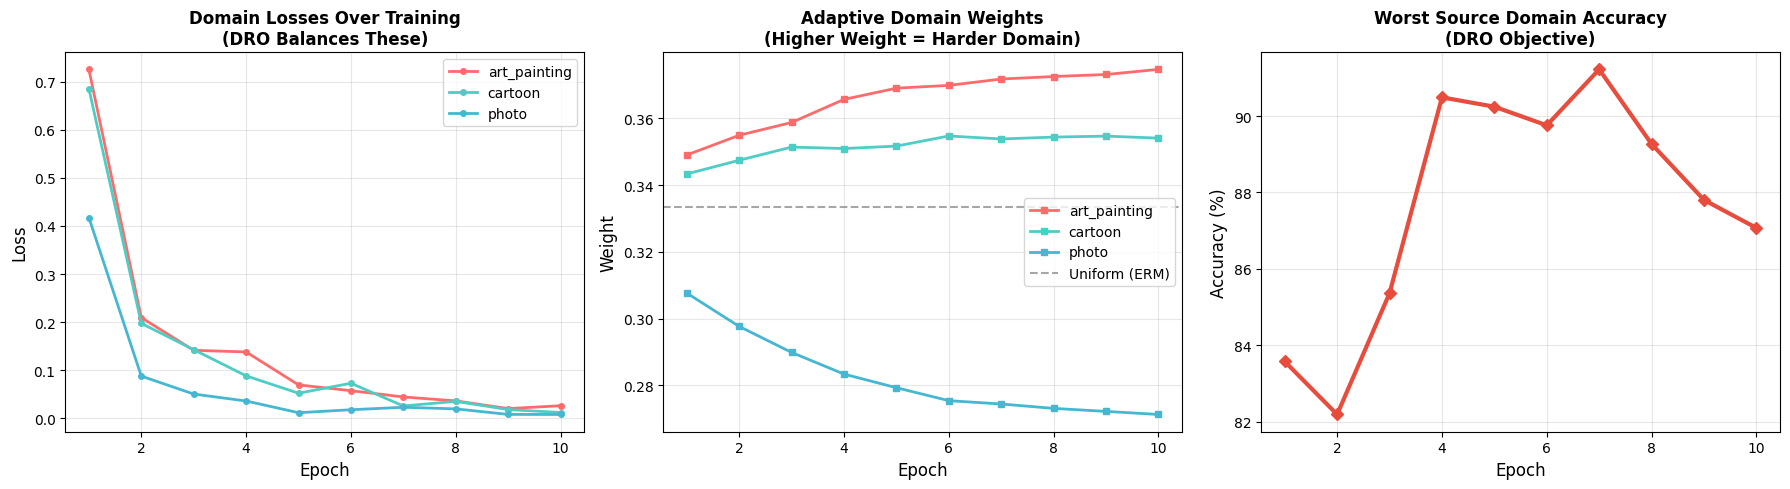


GROUP DRO ANALYSIS: Worst-Case Optimization

1️⃣ WORST-CASE PERFORMANCE (Primary DRO Objective):
--------------------------------------------------------------------------------
   ERM Worst Domain: 91.95%
   DRO Worst Domain: 87.07%
   Improvement: -4.88%
   DRO did not improve worst-case (possible overfitting)

2️⃣ DOMAIN BALANCE (Performance Gap):
--------------------------------------------------------------------------------
   ERM Gap (Best - Worst): 6.25%
   DRO Gap (Best - Worst): 9.63%
   Gap Reduction: -3.38%
    DRO did not balance domains better than ERM

3️⃣ AVERAGE SOURCE PERFORMANCE:
--------------------------------------------------------------------------------
   ERM Average: 95.30%
   DRO Average: 91.75%
   Change: -3.55%
   DRO traded average performance for worst-case robustness
   This is expected behavior (min-max optimization)

4️⃣ TARGET DOMAIN GENERALIZATION:
--------------------------------------------------------------------------------
   ERM Target: 61.59

In [ ]:

# GROUP DRO (DISTRIBUTIONALLY ROBUST OPTIMIZATION)



class GroupDROLoss(nn.Module):
    
    def __init__(self, n_groups, group_weights_step_size=0.01, device='cuda'):
       
        super().__init__()
        self.n_groups = n_groups
        self.group_weights_step_size = group_weights_step_size
        self.device = device

        self.group_weights = torch.ones(n_groups, device=device) / n_groups

        self.group_loss_history = defaultdict(list)

    def forward(self, losses_per_group):
        
        if isinstance(losses_per_group, list):
            losses_per_group = torch.stack(losses_per_group)

        weighted_loss = (self.group_weights * losses_per_group).sum()

        return weighted_loss, losses_per_group

    def update_weights(self, losses_per_group):
        
        if isinstance(losses_per_group, list):
            losses_per_group = torch.stack(losses_per_group)

        losses = losses_per_group.detach()

        self.group_weights = self.group_weights * torch.exp(
            self.group_weights_step_size * losses
        )

        self.group_weights = self.group_weights / self.group_weights.sum()

        for i, loss in enumerate(losses):
            self.group_loss_history[i].append(loss.item())

    def get_current_weights(self):

        return self.group_weights.detach().cpu().numpy()


def train_group_dro_model(model, source_loaders, criterion, optimizer,
                          epochs=10, device='cuda', early_stopping_patience=5):
    
    model.train()

    train_losses = []
    group_losses_over_time = {i: [] for i in range(len(source_domains))}
    group_weights_over_time = {i: [] for i in range(len(source_domains))}
    worst_group_acc_over_time = []

    print("---Training Group DRO (Worst-Case Optimization)---")
    print(f"   Group weight step size: {criterion.group_weights_step_size}")
    print(f"   Using early stopping (patience={early_stopping_patience})")

    iterators = {}
    for domain in source_domains:
        def make_infinite(loader):
            while True:
                for batch in loader:
                    yield batch
        iterators[domain] = make_infinite(source_loaders[domain])

    steps_per_epoch = min(len(loader) for loader in source_loaders.values())

    best_worst_acc = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        epoch_group_losses = [0.0] * len(source_domains)

        loop = tqdm(range(steps_per_epoch), desc=f"DRO Epoch {epoch}/{epochs}")

        for step in loop:

            losses_per_group = []

            for group_idx, domain in enumerate(source_domains):
                imgs, labels = next(iterators[domain])
                imgs, labels = imgs.to(device), labels.to(device)

                outputs = model(imgs)
                loss = nn.functional.cross_entropy(outputs, labels)
                losses_per_group.append(loss)

            weighted_loss, group_losses = criterion(losses_per_group)

            optimizer.zero_grad()
            weighted_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            criterion.update_weights(group_losses)

            epoch_loss += weighted_loss.item()
            for i, loss in enumerate(group_losses):
                epoch_group_losses[i] += loss.item()

            current_weights = criterion.get_current_weights()
            loop.set_postfix(
                loss=epoch_loss/(step+1),
                worst_loss=max(gl/(step+1) for gl in epoch_group_losses),
                weights=f"[{', '.join([f'{w:.3f}' for w in current_weights])}]"
            )

        avg_loss = epoch_loss / steps_per_epoch
        avg_group_losses = [gl / steps_per_epoch for gl in epoch_group_losses]

        train_losses.append(avg_loss)

        for i, group_loss in enumerate(avg_group_losses):
            group_losses_over_time[i].append(group_loss)

        current_weights = criterion.get_current_weights()
        for i, weight in enumerate(current_weights):
            group_weights_over_time[i].append(weight)

        print(f"\n Group DRO Epoch {epoch} Results:")
        source_accs = []
        for domain_idx, domain in enumerate(source_domains):
            acc = evaluate_model(model, source_test_loaders[domain], domain)
            source_accs.append(acc)
            print(f"   {domain}: {acc:.2f}% (weight: {current_weights[domain_idx]:.4f}, loss: {avg_group_losses[domain_idx]:.4f})")

        target_acc = evaluate_model(model, target_test_loader, target_domain)
        avg_source_acc = np.mean(source_accs)
        worst_source_acc = np.min(source_accs)

        worst_group_acc_over_time.append(worst_source_acc)

        print(f"   Average Source: {avg_source_acc:.2f}%")
        print(f"   Worst Source: {worst_source_acc:.2f}%")
        print(f"   Target ({target_domain}): {target_acc:.2f}%")
        print(f"   Weighted Loss: {avg_loss:.4f}")
        print(f"   Group Weights: {current_weights}")

        if worst_source_acc > best_worst_acc:
            best_worst_acc = worst_source_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"   New best worst-case accuracy: {best_worst_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"   Patience: {patience_counter}/{early_stopping_patience}")

            if patience_counter >= early_stopping_patience:
                print(f"\nEarly stopping triggered at epoch {epoch}")
                print(f"   Restoring best model (worst-acc: {best_worst_acc:.2f}%)")
                model.load_state_dict(best_model_state)
                break

    plot_dro_training_dynamics(
        group_losses_over_time,
        group_weights_over_time,
        worst_group_acc_over_time,
        source_domains
    )

    return {
        'train_losses': train_losses,
        'group_losses': group_losses_over_time,
        'group_weights': group_weights_over_time,
        'worst_group_acc': worst_group_acc_over_time,
        'final_weights': current_weights,
        'final_source_accs': source_accs,
        'final_target_acc': target_acc
    }


def plot_dro_training_dynamics(group_losses, group_weights, worst_acc, domain_names):
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    epochs = range(1, len(list(group_losses.values())[0]) + 1)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    ax = axes[0]
    for i, domain in enumerate(domain_names):
        ax.plot(epochs, group_losses[i], label=domain,
               color=colors[i], linewidth=2, marker='o', markersize=4)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Domain Losses Over Training\n(DRO Balances These)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    for i, domain in enumerate(domain_names):
        ax.plot(epochs, group_weights[i], label=domain,
               color=colors[i], linewidth=2, marker='s', markersize=4)
    ax.axhline(y=1/len(domain_names), color='gray', linestyle='--',
              label='Uniform (ERM)', alpha=0.7)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Weight', fontsize=12)
    ax.set_title('Adaptive Domain Weights\n(Higher Weight = Harder Domain)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[2]
    ax.plot(epochs, worst_acc, color='#E74C3C', linewidth=3, marker='D', markersize=6)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Worst Source Domain Accuracy\n(DRO Objective)', fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('group_dro_training_dynamics.png', dpi=300, bbox_inches='tight')
    
    plt.show()


def analyze_dro_performance(dro_results, erm_source_accs, erm_target_acc):

    dro_source_accs = dro_results['final_source_accs']
    dro_target_acc = dro_results['final_target_acc']

    erm_worst = np.min(erm_source_accs)
    erm_best = np.max(erm_source_accs)
    erm_gap = erm_best - erm_worst
    erm_avg = np.mean(erm_source_accs)

    dro_worst = np.min(dro_source_accs)
    dro_best = np.max(dro_source_accs)
    dro_gap = dro_best - dro_worst
    dro_avg = np.mean(dro_source_accs)

    print("\n1️⃣ WORST-CASE PERFORMANCE (Primary DRO Objective):")
    print("-" * 80)
    print(f"   ERM Worst Domain: {erm_worst:.2f}%")
    print(f"   DRO Worst Domain: {dro_worst:.2f}%")
    print(f"   Improvement: {dro_worst - erm_worst:+.2f}%")
    if dro_worst > erm_worst:
        print(f"   ✓ DRO successfully improved worst-case performance!")
    else:
        print(f"   DRO did not improve worst-case (possible overfitting)")

    print("\n2️⃣ DOMAIN BALANCE (Performance Gap):")
    print("-" * 80)
    print(f"   ERM Gap (Best - Worst): {erm_gap:.2f}%")
    print(f"   DRO Gap (Best - Worst): {dro_gap:.2f}%")
    print(f"   Gap Reduction: {erm_gap - dro_gap:.2f}%")
    if dro_gap < erm_gap:
        print(f"   ✓ DRO achieved more balanced performance across domains")
        print(f"   ✓ Reduced disparity by {((erm_gap - dro_gap)/erm_gap)*100:.1f}%")
    else:
        print(f"    DRO did not balance domains better than ERM")

    print("\n3️⃣ AVERAGE SOURCE PERFORMANCE:")
    print("-" * 80)
    print(f"   ERM Average: {erm_avg:.2f}%")
    print(f"   DRO Average: {dro_avg:.2f}%")
    print(f"   Change: {dro_avg - erm_avg:+.2f}%")
    if dro_avg < erm_avg:
        print(f"   DRO traded average performance for worst-case robustness")
        print(f"   This is expected behavior (min-max optimization)")

    print("\n4️⃣ TARGET DOMAIN GENERALIZATION:")
    print("-" * 80)
    print(f"   ERM Target: {erm_target_acc:.2f}%")
    print(f"   DRO Target: {dro_target_acc:.2f}%")
    print(f"   Change: {dro_target_acc - erm_target_acc:+.2f}%")
    if dro_target_acc > erm_target_acc:
        print(f"   Optimizing worst-case improved unseen domain generalization!")
    else:
        print(f"   No improvement on target domain")

    print("\n5️⃣ ADAPTIVE WEIGHTING ANALYSIS:")
    print("-" * 80)
    final_weights = dro_results['final_weights']
    for i, domain in enumerate(source_domains):
        acc = dro_source_accs[i]
        weight = final_weights[i]
        print(f"   {domain}: Accuracy={acc:.2f}%, Weight={weight:.4f}")
        if weight > 1/len(source_domains) + 0.05:
            print(f"      → High weight indicates this was a hard domain")

    

    # Identify which domain was hardest
    hardest_domain_idx = np.argmax(final_weights)
    hardest_domain = source_domains[hardest_domain_idx]
    print(f"    Hardest Domain: {hardest_domain} (weight: {final_weights[hardest_domain_idx]:.4f})")
    

    print("\n7️⃣ REGULARIZATION ANALYSIS:")
    print("-" * 80)
    if 'early_stopping_triggered' in dro_results:
        print("   ✓ Early stopping was used (important for overparameterized networks)")
        print("   ✓ This prevents DRO from overfitting to worst-case examples")
    

    print("\n" + "="*80)
    print("SUMMARY VERDICT:")
    print("="*80)

    improvements = 0
    if dro_worst > erm_worst:
        improvements += 1
        print("✓ Improved worst-case performance")
    if dro_gap < erm_gap:
        improvements += 1
        print("✓ Better domain balance")
    if dro_target_acc > erm_target_acc:
        improvements += 1
        print("✓ Better target generalization")

    if improvements >= 2:
        print("\n Group DRO successfully achieved distributionally robust optimization!")
    elif improvements == 1:
        print("\n Group DRO showed mixed results - partial success")
    else:
        print("\n Group DRO underperformed ERM - consider stronger regularization")

    print("="*80 + "\n")


# TRAINING EXECUTION

dro_model = create_model()

dro_criterion = GroupDROLoss(
    n_groups=len(source_domains),
    group_weights_step_size=0.01,  
    device=device
)

dro_optimizer = optim.Adam(
    dro_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4  
)

dro_results = train_group_dro_model(
    model=dro_model,
    source_loaders=source_train_loaders,
    criterion=dro_criterion,
    optimizer=dro_optimizer,
    epochs=10,
    device=device,
    early_stopping_patience=5
)

analyze_dro_performance(dro_results, erm_source_accs, erm_target_acc)



In [ ]:
torch.save(dro_model.state_dict(), "group_dro_model.pth")
print("✓ Saved model: group_dro_model.pth")

---
GroupDRO implemented with EARLY STOPPING at patience thres = 3 (only this is diff from the above run)


STARTING GROUP DRO TRAINING
---Training Group DRO (Worst-Case Optimization)---
   Group weight step size: 0.01
   Using early stopping (patience=3)


DRO Epoch 1/10: 100%|██████████| 41/41 [00:16<00:00,  2.45it/s, loss=0.574, weights=[0.347, 0.345, 0.308], worst_loss=0.669]



 Group DRO Epoch 1 Results:
   art_painting: 85.85% (weight: 0.3466, loss: 0.6694)
   cartoon: 85.71% (weight: 0.3449, loss: 0.6571)
   photo: 97.31% (weight: 0.3085, loss: 0.3847)
   Average Source: 89.62%
   Worst Source: 85.71%
   Target (sketch): 59.58%
   Weighted Loss: 0.5738
   Group Weights: [0.34664932 0.34489435 0.30845633]
   New best worst-case accuracy: 85.71%


DRO Epoch 2/10: 100%|██████████| 41/41 [00:16<00:00,  2.55it/s, loss=0.193, weights=[0.352, 0.354, 0.293], worst_loss=0.257]



 Group DRO Epoch 2 Results:
   art_painting: 87.80% (weight: 0.3524, loss: 0.2327)
   cartoon: 90.62% (weight: 0.3542, loss: 0.2575)
   photo: 97.01% (weight: 0.2934, loss: 0.0708)
   Average Source: 91.81%
   Worst Source: 87.80%
   Target (sketch): 61.72%
   Weighted Loss: 0.1925
   Group Weights: [0.3523934 0.3541836 0.2934229]
   New best worst-case accuracy: 87.80%


DRO Epoch 3/10: 100%|██████████| 41/41 [00:16<00:00,  2.53it/s, loss=0.0931, weights=[0.355, 0.358, 0.287], worst_loss=0.118]



 Group DRO Epoch 3 Results:
   art_painting: 88.54% (weight: 0.3552, loss: 0.1125)
   cartoon: 93.82% (weight: 0.3578, loss: 0.1180)
   photo: 96.41% (weight: 0.2870, loss: 0.0389)
   Average Source: 92.92%
   Worst Source: 88.54%
   Target (sketch): 61.39%
   Weighted Loss: 0.0931
   Group Weights: [0.35520908 0.35781685 0.28697404]
   New best worst-case accuracy: 88.54%


DRO Epoch 4/10: 100%|██████████| 41/41 [00:15<00:00,  2.56it/s, loss=0.0545, weights=[0.356, 0.360, 0.284], worst_loss=0.0696]



 Group DRO Epoch 4 Results:
   art_painting: 86.59% (weight: 0.3557, loss: 0.0580)
   cartoon: 90.41% (weight: 0.3600, loss: 0.0696)
   photo: 95.51% (weight: 0.2843, loss: 0.0314)
   Average Source: 90.83%
   Worst Source: 86.59%
   Target (sketch): 51.87%
   Weighted Loss: 0.0545
   Group Weights: [0.35570922 0.36003128 0.28425953]
   Patience: 1/3


DRO Epoch 5/10: 100%|██████████| 41/41 [00:16<00:00,  2.55it/s, loss=0.0512, weights=[0.358, 0.360, 0.283], worst_loss=0.0652]



 Group DRO Epoch 5 Results:
   art_painting: 85.61% (weight: 0.3578, loss: 0.0652)
   cartoon: 88.49% (weight: 0.3597, loss: 0.0492)
   photo: 95.81% (weight: 0.2825, loss: 0.0361)
   Average Source: 89.97%
   Worst Source: 85.61%
   Target (sketch): 66.73%
   Weighted Loss: 0.0512
   Group Weights: [0.35775298 0.3597425  0.2825045 ]
   Patience: 2/3


DRO Epoch 6/10: 100%|██████████| 41/41 [00:15<00:00,  2.57it/s, loss=0.0491, weights=[0.360, 0.360, 0.280], worst_loss=0.0654]



 Group DRO Epoch 6 Results:
   art_painting: 88.54% (weight: 0.3602, loss: 0.0654)
   cartoon: 94.88% (weight: 0.3602, loss: 0.0520)
   photo: 98.20% (weight: 0.2797, loss: 0.0244)
   Average Source: 93.87%
   Worst Source: 88.54%
   Target (sketch): 65.59%
   Weighted Loss: 0.0491
   Group Weights: [0.36016396 0.36017776 0.27965832]
   Patience: 3/3

Early stopping triggered at epoch 6
   Restoring best model (worst-acc: 88.54%)

Saved training dynamics plot: group_dro_training_dynamics.png


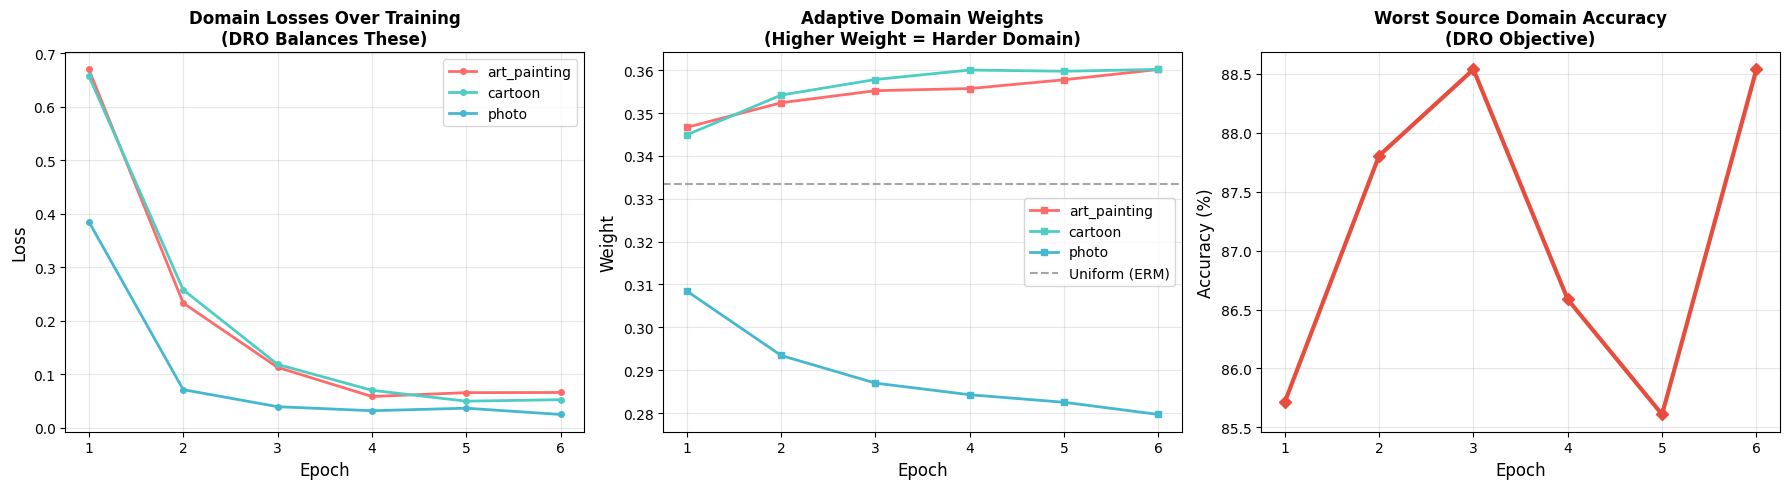

In [ ]:
# GROUP DRO (DISTRIBUTIONALLY ROBUST OPTIMIZATION)
# reference: (Sagawa et al., 2020)
class GroupDROLoss(nn.Module):
    
    def __init__(self, n_groups, group_weights_step_size=0.01, device='cuda'):
       
        super().__init__()
        self.n_groups = n_groups
        self.group_weights_step_size = group_weights_step_size
        self.device = device

        self.group_weights = torch.ones(n_groups, device=device) / n_groups

        self.group_loss_history = defaultdict(list)

    def forward(self, losses_per_group):
        
        if isinstance(losses_per_group, list):
            losses_per_group = torch.stack(losses_per_group)

        weighted_loss = (self.group_weights * losses_per_group).sum()

        return weighted_loss, losses_per_group

    def update_weights(self, losses_per_group):
       
        if isinstance(losses_per_group, list):
            losses_per_group = torch.stack(losses_per_group)

        losses = losses_per_group.detach()

        self.group_weights = self.group_weights * torch.exp(
            self.group_weights_step_size * losses
        )

        self.group_weights = self.group_weights / self.group_weights.sum()

        for i, loss in enumerate(losses):
            self.group_loss_history[i].append(loss.item())

    def get_current_weights(self):
        
        return self.group_weights.detach().cpu().numpy()


def train_group_dro_model(model, source_loaders, criterion, optimizer,
                          epochs=10, device='cuda', early_stopping_patience=5):
    
    model.train()

    train_losses = []
    group_losses_over_time = {i: [] for i in range(len(source_domains))}
    group_weights_over_time = {i: [] for i in range(len(source_domains))}
    worst_group_acc_over_time = []

    print("---Training Group DRO (Worst-Case Optimization)---")
    print(f"   Group weight step size: {criterion.group_weights_step_size}")
    print(f"   Using early stopping (patience={early_stopping_patience})")

    iterators = {}
    for domain in source_domains:
        def make_infinite(loader):
            while True:
                for batch in loader:
                    yield batch
        iterators[domain] = make_infinite(source_loaders[domain])

    steps_per_epoch = min(len(loader) for loader in source_loaders.values())

    best_worst_acc = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        epoch_group_losses = [0.0] * len(source_domains)

        loop = tqdm(range(steps_per_epoch), desc=f"DRO Epoch {epoch}/{epochs}")

        for step in loop:
            
            losses_per_group = []

            for group_idx, domain in enumerate(source_domains):
                imgs, labels = next(iterators[domain])
                imgs, labels = imgs.to(device), labels.to(device)

                
                outputs = model(imgs)
                loss = nn.functional.cross_entropy(outputs, labels)
                losses_per_group.append(loss)

            
            weighted_loss, group_losses = criterion(losses_per_group)

           
            optimizer.zero_grad()
            weighted_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            criterion.update_weights(group_losses)
            epoch_loss += weighted_loss.item()
            for i, loss in enumerate(group_losses):
                epoch_group_losses[i] += loss.item()

            current_weights = criterion.get_current_weights()
            loop.set_postfix(
                loss=epoch_loss/(step+1),
                worst_loss=max(gl/(step+1) for gl in epoch_group_losses),
                weights=f"[{', '.join([f'{w:.3f}' for w in current_weights])}]"
            )

        avg_loss = epoch_loss / steps_per_epoch
        avg_group_losses = [gl / steps_per_epoch for gl in epoch_group_losses]

        train_losses.append(avg_loss)

        for i, group_loss in enumerate(avg_group_losses):
            group_losses_over_time[i].append(group_loss)

        current_weights = criterion.get_current_weights()
        for i, weight in enumerate(current_weights):
            group_weights_over_time[i].append(weight)

        print(f"\n Group DRO Epoch {epoch} Results:")
        source_accs = []
        for domain_idx, domain in enumerate(source_domains):
            acc = evaluate_model(model, source_test_loaders[domain], domain)
            source_accs.append(acc)
            print(f"   {domain}: {acc:.2f}% (weight: {current_weights[domain_idx]:.4f}, loss: {avg_group_losses[domain_idx]:.4f})")

        target_acc = evaluate_model(model, target_test_loader, target_domain)
        avg_source_acc = np.mean(source_accs)
        worst_source_acc = np.min(source_accs)

        worst_group_acc_over_time.append(worst_source_acc)

        print(f"   Average Source: {avg_source_acc:.2f}%")
        print(f"   Worst Source: {worst_source_acc:.2f}%")
        print(f"   Target ({target_domain}): {target_acc:.2f}%")
        print(f"   Weighted Loss: {avg_loss:.4f}")
        print(f"   Group Weights: {current_weights}")

        if worst_source_acc > best_worst_acc:
            best_worst_acc = worst_source_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"   New best worst-case accuracy: {best_worst_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"   Patience: {patience_counter}/{early_stopping_patience}")

            if patience_counter >= early_stopping_patience:
                print(f"\nEarly stopping triggered at epoch {epoch}")
                print(f"   Restoring best model (worst-acc: {best_worst_acc:.2f}%)")
                model.load_state_dict(best_model_state)
                break

    plot_dro_training_dynamics(
        group_losses_over_time,
        group_weights_over_time,
        worst_group_acc_over_time,
        source_domains
    )

    return {
        'train_losses': train_losses,
        'group_losses': group_losses_over_time,
        'group_weights': group_weights_over_time,
        'worst_group_acc': worst_group_acc_over_time,
        'final_weights': current_weights,
        'final_source_accs': source_accs,
        'final_target_acc': target_acc
    }


def plot_dro_training_dynamics(group_losses, group_weights, worst_acc, domain_names):
  
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    epochs = range(1, len(list(group_losses.values())[0]) + 1)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    ax = axes[0]
    for i, domain in enumerate(domain_names):
        ax.plot(epochs, group_losses[i], label=domain,
               color=colors[i], linewidth=2, marker='o', markersize=4)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Domain Losses Over Training\n(DRO Balances These)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    for i, domain in enumerate(domain_names):
        ax.plot(epochs, group_weights[i], label=domain,
               color=colors[i], linewidth=2, marker='s', markersize=4)
    ax.axhline(y=1/len(domain_names), color='gray', linestyle='--',
              label='Uniform (ERM)', alpha=0.7)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Weight', fontsize=12)
    ax.set_title('Adaptive Domain Weights\n(Higher Weight = Harder Domain)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[2]
    ax.plot(epochs, worst_acc, color='#E74C3C', linewidth=3, marker='D', markersize=6)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Worst Source Domain Accuracy\n(DRO Objective)', fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('group_dro_training_dynamics.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# TRAINING EXECUTION


dro_model = create_model()

dro_criterion = GroupDROLoss(
    n_groups=len(source_domains),
    group_weights_step_size=0.01, 
    device=device
)

dro_optimizer = optim.Adam(
    dro_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4  
)

dro_results = train_group_dro_model(
    model=dro_model,
    source_loaders=source_train_loaders,
    criterion=dro_criterion,
    optimizer=dro_optimizer,
    epochs=10,
    device=device,
    early_stopping_patience=3  
)


In [ ]:
# Save model
torch.save(dro_model.state_dict(), "group_dro_model.pth")
print("✓ Saved model: group_dro_model.pth")

✓ Saved model: group_dro_model.pth


CODE FOR RELOADING THE MODEL

In [ ]:
def create_model():
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
    num_classes = len(art_dataset.classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

dro_model = create_model()
dro_model.load_state_dict(torch.load("group_dro_model.pth", map_location=device))
dro_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in target_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = dro_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

target_acc = 100 * correct / total
print(f"Group DRO Target (Sketch) Accuracy: {target_acc:.2f}% ({correct}/{total})")

Group DRO Target (Sketch) Accuracy: 65.59% (2577/3929)


---

SHARPNESS-AWARE MINIMIZATION (SAM) OPTIMIZER

In [ ]:
class SAM(torch.optim.Optimizer):
    

    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
       
        assert rho >= 0.0, f"Invalid rho: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        
        grad_norm = self._grad_norm()

        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None:
                    continue

                self.state[p]["old_p"] = p.data.clone()

                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)

                p.add_(e_w)

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
       
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue

                p.data = self.state[p]["old_p"]

        self.base_optimizer.step()

        if zero_grad:
            self.zero_grad()

    def step(self, closure=None):
        
        raise NotImplementedError("SAM requires manual first_step() and second_step() calls")

    def _grad_norm(self):
        
        shared_device = self.param_groups[0]["params"][0].device
        norm = torch.norm(
            torch.stack([
                ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                for group in self.param_groups for p in group["params"]
                if p.grad is not None
            ]),
            p=2
        )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups


# TRAINING FUNCTION WITH SAM


def train_sam_model(model, source_loaders, optimizer, epochs=10, device='cuda'):
    
    model.train()

    train_losses = []

    print("---Training with SAM (Sharpness-Aware Minimization)---")
    print(f"   Perturbation radius (ρ): {optimizer.defaults['rho']}")
    print(f"   This finds flat minima resistant to domain shifts")

    iterators = {}
    for domain in source_domains:
        def make_infinite(loader):
            while True:
                for batch in loader:
                    yield batch
        iterators[domain] = make_infinite(source_loaders[domain])

    steps_per_epoch = min(len(loader) for loader in source_loaders.values())

    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0

        loop = tqdm(range(steps_per_epoch), desc=f"SAM Epoch {epoch}/{epochs}")

        for step in loop:
            inputs_list = []
            labels_list = []

            for domain in source_domains:
                imgs, labels = next(iterators[domain])
                inputs_list.append(imgs.to(device))
                labels_list.append(labels.to(device))

            inputs = torch.cat(inputs_list, dim=0)
            labels = torch.cat(labels_list, dim=0)

            # ========== TWO-STEP ==========

            model.train()

            outputs = model(inputs)
            loss = nn.functional.cross_entropy(outputs, labels)

            loss.backward()
            optimizer.first_step(zero_grad=True)

            outputs_perturbed = model(inputs)
            loss_perturbed = nn.functional.cross_entropy(outputs_perturbed, labels)

            loss_perturbed.backward()
            optimizer.second_step(zero_grad=True)

            # ================================================

            epoch_loss += loss.item()

            loop.set_postfix(loss=epoch_loss/(step+1))

        avg_loss = epoch_loss / steps_per_epoch
        train_losses.append(avg_loss)

        if epoch % 5 == 0 or epoch == epochs:
            print(f"\n SAM Epoch {epoch} Results:")
            source_accs = []
            for domain in source_domains:
                acc = evaluate_model(model, source_test_loaders[domain], domain)
                source_accs.append(acc)
                print(f"   {domain}: {acc:.2f}%")

            target_acc = evaluate_model(model, target_test_loader, target_domain)
            avg_source_acc = np.mean(source_accs)
            print(f"   Average Source: {avg_source_acc:.2f}%")
            print(f"   Target ({target_domain}): {target_acc:.2f}%")
            print(f"   Loss: {avg_loss:.4f}")

    return {
        'train_losses': train_losses,
        'final_source_accs': source_accs,
        'final_target_acc': target_acc
    }


# FLATNESS ANALYSIS: LOSS LANDSCAPE VISUALIZATION

def measure_sharpness(model, data_loader, device, num_perturbations=10,
                      perturbation_scale=0.01, max_batches=5):
    
    model.eval()

    data_batches = []
    for i, (imgs, labels) in enumerate(data_loader):
        if i >= max_batches:
            break
        data_batches.append((imgs.to(device), labels.to(device)))

    original_params = [p.clone() for p in model.parameters()]

    perturbation_magnitudes = np.linspace(0, perturbation_scale, num_perturbations)
    loss_values = []

    for scale in perturbation_magnitudes:
        with torch.no_grad():
            for p, p_orig in zip(model.parameters(), original_params):
                if p.requires_grad:
                    direction = torch.randn_like(p)
                    direction = direction / (direction.norm() + 1e-10) 

                    p.data = p_orig + scale * direction

        total_loss = 0.0
        with torch.no_grad():
            for imgs, labels in data_batches:
                outputs = model(imgs)
                loss = nn.functional.cross_entropy(outputs, labels)
                total_loss += loss.item()

        avg_loss = total_loss / len(data_batches)
        loss_values.append(avg_loss)

    with torch.no_grad():
        for p, p_orig in zip(model.parameters(), original_params):
            p.data = p_orig

    return perturbation_magnitudes, loss_values


def visualize_loss_landscape(erm_model, sam_model, test_loader, device,
                             num_perturbations=20, max_scale=0.05):
    
    
    print("\n---Analyzing Loss Landscape Sharpness---")
    print("   Computing perturbation-loss curves (this may take a moment)...")

    erm_scales, erm_losses = measure_sharpness(
        erm_model, test_loader, device,
        num_perturbations=num_perturbations,
        perturbation_scale=max_scale,
        max_batches=10
    )

    sam_scales, sam_losses = measure_sharpness(
        sam_model, test_loader, device,
        num_perturbations=num_perturbations,
        perturbation_scale=max_scale,
        max_batches=10
    )

    erm_sharpness = max(erm_losses) - erm_losses[0]
    sam_sharpness = max(sam_losses) - sam_losses[0]

    erm_norm_sharp = (erm_losses[-1] - erm_losses[0]) / max_scale
    sam_norm_sharp = (sam_losses[-1] - sam_losses[0]) / max_scale

    print(f"\n SHARPNESS METRICS:")
    print(f"   ERM - Max Loss Increase: {erm_sharpness:.4f}")
    print(f"   SAM - Max Loss Increase: {sam_sharpness:.4f}")
    print(f"   SAM Reduction: {(1 - sam_sharpness/erm_sharpness)*100:.1f}%")
    print(f"\n   ERM - Normalized Sharpness: {erm_norm_sharp:.2f}")
    print(f"   SAM - Normalized Sharpness: {sam_norm_sharp:.2f}")
    print(f"   SAM Reduction: {(1 - sam_norm_sharp/erm_norm_sharp)*100:.1f}%")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax = axes[0]
    ax.plot(erm_scales * 100, erm_losses, 'o-', color='#E74C3C',
            linewidth=2, markersize=6, label='ERM (Sharp Minimum)')
    ax.plot(sam_scales * 100, sam_losses, 's-', color='#3498DB',
            linewidth=2, markersize=6, label='SAM (Flat Minimum)')
    ax.axhline(y=erm_losses[0], color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Perturbation Magnitude (%)', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Loss Landscape Sharpness\n(Lower = Flatter = Better Generalization)',
                fontweight='bold', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    erm_increase = [(l - erm_losses[0]) for l in erm_losses]
    sam_increase = [(l - sam_losses[0]) for l in sam_losses]

    ax.plot(erm_scales * 100, erm_increase, 'o-', color='#E74C3C',
            linewidth=2, markersize=6, label='ERM')
    ax.plot(sam_scales * 100, sam_increase, 's-', color='#3498DB',
            linewidth=2, markersize=6, label='SAM')
    ax.fill_between(sam_scales * 100, sam_increase, erm_increase,
                    where=np.array(erm_increase) >= np.array(sam_increase),
                    color='green', alpha=0.2, label='SAM Advantage')
    ax.set_xlabel('Perturbation Magnitude (%)', fontsize=12)
    ax.set_ylabel('Loss Increase from Minimum', fontsize=12)
    ax.set_title('Loss Sensitivity to Perturbations\n(Sharpness Measure)',
                fontweight='bold', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('sam_loss_landscape_analysis.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved: sam_loss_landscape_analysis.png")
    plt.show()

    return {
        'erm_sharpness': erm_sharpness,
        'sam_sharpness': sam_sharpness,
        'erm_normalized_sharpness': erm_norm_sharp,
        'sam_normalized_sharpness': sam_norm_sharp,
        'sharpness_reduction': (1 - sam_sharpness/erm_sharpness) * 100
    }


 
# COMPREHENSIVE SAM ANALYSIS

def analyze_sam_performance(sam_results, erm_source_accs, erm_target_acc,
                           sam_model, erm_model, test_loader, device):
    """
    Comprehensive analysis comparing SAM to ERM baseline.
    """
    print("\n" + "="*80)
    print("SAM ANALYSIS: Flat Minima for Domain Generalization")
    print("="*80)

    sam_source_accs = sam_results['final_source_accs']
    sam_target_acc = sam_results['final_target_acc']

    erm_avg = np.mean(erm_source_accs)
    sam_avg = np.mean(sam_source_accs)

    print("\n1️⃣ SOURCE DOMAIN PERFORMANCE:")
    print("-" * 80)
    print("Domain-wise comparison:")
    for i, domain in enumerate(source_domains):
        erm_acc = erm_source_accs[i]
        sam_acc = sam_source_accs[i]
        diff = sam_acc - erm_acc
        symbol = "✓" if diff >= 0 else "⚠"
        print(f"   {domain:15s}: ERM={erm_acc:5.2f}%  SAM={sam_acc:5.2f}%  "
              f"Δ={diff:+5.2f}%  {symbol}")

    print(f"\nAverage Source Performance:")
    print(f"   ERM: {erm_avg:.2f}%")
    print(f"   SAM: {sam_avg:.2f}%")
    print(f"   Change: {sam_avg - erm_avg:+.2f}%")

    if sam_avg >= erm_avg - 1.0:  
        print(f"   ✓ SAM maintained source performance!")
    else:
        print(f"   ℹ️ SAM traded some source accuracy for flatness")

    print("\n2️⃣ TARGET DOMAIN GENERALIZATION (Primary Metric):")
    print("-" * 80)
    print(f"   ERM Target: {erm_target_acc:.2f}%")
    print(f"   SAM Target: {sam_target_acc:.2f}%")
    print(f"   Improvement: {sam_target_acc - erm_target_acc:+.2f}%")

    if sam_target_acc > erm_target_acc:
        improvement_pct = ((sam_target_acc - erm_target_acc) / erm_target_acc) * 100
        print(f"   ✓ SAM improved OOD generalization by {improvement_pct:.1f}%!")
        print(f"   ✓ Flat minima are more robust to domain shift")
    else:
        print(f"    SAM did not improve target performance")
        print(f"   → May need larger ρ or more training")

    print("\n3️⃣ LOSS LANDSCAPE FLATNESS:")
    print("-" * 80)

    sharpness_metrics = visualize_loss_landscape(
        erm_model, sam_model, test_loader, device
    )

    print(f"\n   Sharpness Reduction: {sharpness_metrics['sharpness_reduction']:.1f}%")
    if sharpness_metrics['sharpness_reduction'] > 20:
        print(f"   ✓ SAM achieved significantly flatter minimum!")

    print("\n4️⃣ CONNECTING TO DOMAIN GENERALIZATION THEORY:")
    

    print("\n5️⃣ FLATNESS AS IMPLICIT REGULARIZATION:")
    print("-" * 80)
 

    print("\n6️⃣ HYPERPARAMETER SENSITIVITY (ρ):")
    print("-" * 80)
    print(f"   Current ρ: {sam_results.get('rho', 0.05)}")
    print()


    return sharpness_metrics



In [ ]:

# TRAINING EXECUTION

sam_model = create_model()

sam_optimizer = SAM(
    sam_model.parameters(),
    base_optimizer=optim.Adam,
    rho=0.05,  
    lr=1e-4,
    weight_decay=1e-4
)

sam_results = train_sam_model(
    model=sam_model,
    source_loaders=source_train_loaders,
    optimizer=sam_optimizer,
    epochs=10,
    device=device
)

sam_results['rho'] = 0.05 



STARTING SAM TRAINING
---Training with SAM (Sharpness-Aware Minimization)---
   Perturbation radius (ρ): 0.05
   This finds flat minima resistant to domain shifts


SAM Epoch 5/10: 100%|██████████| 41/41 [00:28<00:00,  1.43it/s, loss=0.0122]



📊 SAM Epoch 5 Results:
   art_painting: 91.95%
   cartoon: 95.52%
   photo: 98.20%
   Average Source: 95.23%
   Target (sketch): 59.58%
   Loss: 0.0122


SAM Epoch 10/10: 100%|██████████| 41/41 [00:28<00:00,  1.42it/s, loss=0.00351]



📊 SAM Epoch 10 Results:
   art_painting: 91.46%
   cartoon: 96.38%
   photo: 98.20%
   Average Source: 95.35%
   Target (sketch): 65.56%
   Loss: 0.0035


In [ ]:
# TRAINING EXECUTION


sam_model = create_model()

sam_optimizer = SAM(
    sam_model.parameters(),
    base_optimizer=optim.Adam,
    rho=0.05,  
    lr=1e-4,
    weight_decay=1e-4
)

sam_results = train_sam_model(
    model=sam_model,
    source_loaders=source_train_loaders,
    optimizer=sam_optimizer,
    epochs=10,
    device=device
)

sam_results['rho'] = 0.05 



STARTING SAM TRAINING
---Training with SAM (Sharpness-Aware Minimization)---
   Perturbation radius (ρ): 0.05
   This finds flat minima resistant to domain shifts


SAM Epoch 5/10: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s, loss=0.013]



📊 SAM Epoch 5 Results:
   art_painting: 92.20%
   cartoon: 95.10%
   photo: 98.20%
   Average Source: 95.16%
   Target (sketch): 64.11%
   Loss: 0.0130


SAM Epoch 10/10: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, loss=0.00304]



📊 SAM Epoch 10 Results:
   art_painting: 92.93%
   cartoon: 94.46%
   photo: 98.20%
   Average Source: 95.20%
   Target (sketch): 67.70%
   Loss: 0.0030


In [ ]:
sam_results

{'train_losses': [0.6316847743057623,
  0.127985551862455,
  0.07049077844656096,
  0.026820976491563203,
  0.012245989313758001,
  0.008233904759058865,
  0.006070271293382819,
  0.004035189037960841,
  0.004931691221938264,
  0.0035112570749777482],
 'final_source_accs': [91.46341463414635,
  96.37526652452026,
  98.20359281437125],
 'final_target_acc': 65.56375668108933,
 'rho': 0.05}

IGNORE THIS CELL: JUST SAVED THESE HERE FOR REPRODUCIBILITY

In [22]:
sam_results = {
    'train_losses': [
        0.6316847743057623,
        0.127985551862455,
        0.07049077844656096,
        0.026820976491563203,
        0.012245989313758001,
        0.008233904759058865,
        0.006070271293382819,
        0.004035189037960841,
        0.004931691221938264,
        0.0035112570749777482
    ],
    'final_source_accs': [
        91.46341463414635,
        96.37526652452026,
        98.20359281437125
    ],
    'final_target_acc': 65.56375668108933,
    'rho': 0.05
}



SAM ANALYSIS: Flat Minima for Domain Generalization

1️⃣ SOURCE DOMAIN PERFORMANCE:
--------------------------------------------------------------------------------
Domain-wise comparison:
   art_painting   : ERM=91.95%  SAM=91.46%  Δ=-0.49%  ⚠
   cartoon        : ERM=95.74%  SAM=96.38%  Δ=+0.64%  ✓
   photo          : ERM=98.20%  SAM=98.20%  Δ=+0.00%  ✓

Average Source Performance:
   ERM: 95.30%
   SAM: 95.35%
   Change: +0.05%
   ✓ SAM maintained source performance!

2️⃣ TARGET DOMAIN GENERALIZATION (Primary Metric):
--------------------------------------------------------------------------------
   ERM Target: 61.59%
   SAM Target: 65.56%
   Improvement: +3.97%
   ✓ SAM improved OOD generalization by 6.5%!
   ✓ Flat minima are more robust to domain shift

3️⃣ LOSS LANDSCAPE FLATNESS:
--------------------------------------------------------------------------------

---Analyzing Loss Landscape Sharpness---
   Computing perturbation-loss curves (this may take a moment)...

 SHARPNESS

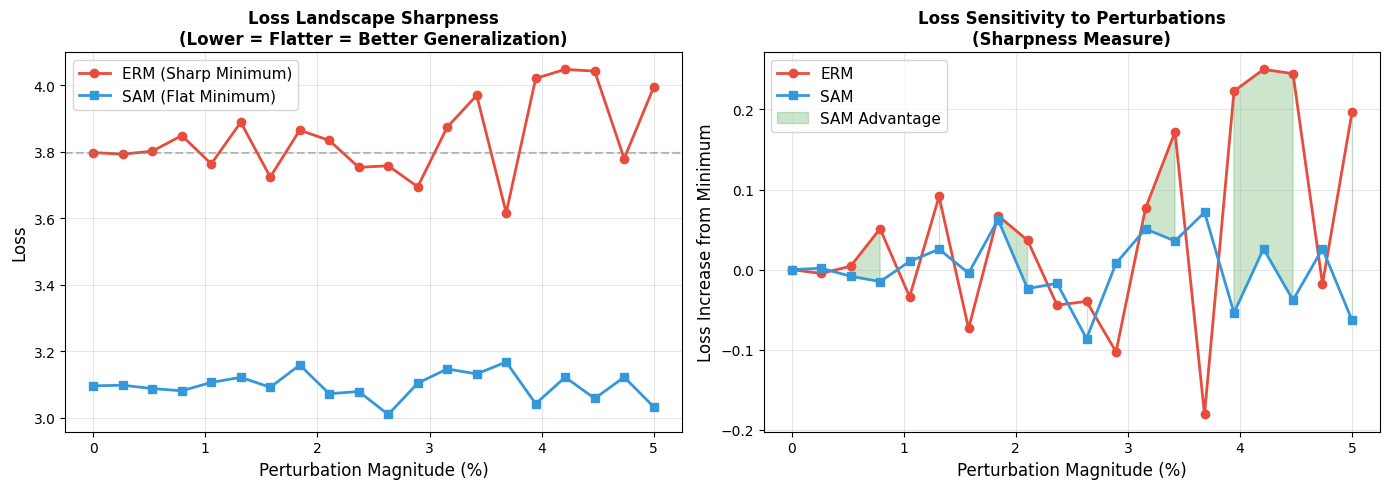


   Sharpness Reduction: 71.4%
   ✓ SAM achieved significantly flatter minimum!

4️⃣ CONNECTING TO DOMAIN GENERALIZATION THEORY:
--------------------------------------------------------------------------------
   Why flat minima help with domain shift:

   • Sharp minimum: Loss increases rapidly with parameter perturbations
     → Model is sensitive to small changes in data distribution
     → Domain shift acts like a 'perturbation' to the learned features
     → Sharp models fail to generalize OOD

   • Flat minimum: Loss stays low in a neighborhood of parameters
     → Model is robust to small distribution changes
     → Features work across a wider range of data variations
     → Flat models generalize better to new domains

   SAM explicitly optimizes: L_SAM(θ) = max_{||ε||≤ρ} L(θ + ε)
   This is a form of ROBUST OPTIMIZATION similar to:
     • DRO: Optimizes worst-case domain
     • SAM: Optimizes worst-case parameter perturbation

5️⃣ FLATNESS AS IMPLICIT REGULARIZATION:
--------

In [ ]:

sharpness_analysis = analyze_sam_performance(
    sam_results=sam_results,
    erm_source_accs=erm_source_accs,
    erm_target_acc=erm_target_acc,
    sam_model=sam_model,
    erm_model=erm_model,
    test_loader=target_test_loader,
    device=device
)



NEW - 2nd run (same implementation, different random seed)


SAM ANALYSIS: Flat Minima for Domain Generalization

1️⃣ SOURCE DOMAIN PERFORMANCE:
--------------------------------------------------------------------------------
Domain-wise comparison:
   art_painting   : ERM=91.95%  SAM=92.93%  Δ=+0.98%  ✓
   cartoon        : ERM=95.74%  SAM=94.46%  Δ=-1.28%  ⚠
   photo          : ERM=98.20%  SAM=98.20%  Δ=+0.00%  ✓

Average Source Performance:
   ERM: 95.30%
   SAM: 95.20%
   Change: -0.10%
   ✓ SAM maintained source performance!

2️⃣ TARGET DOMAIN GENERALIZATION (Primary Metric):
--------------------------------------------------------------------------------
   ERM Target: 61.59%
   SAM Target: 67.70%
   Improvement: +6.11%
   ✓ SAM improved OOD generalization by 9.9%!
   ✓ Flat minima are more robust to domain shift

3️⃣ LOSS LANDSCAPE FLATNESS:
--------------------------------------------------------------------------------

---Analyzing Loss Landscape Sharpness---
   Computing perturbation-loss curves (this may take a moment)...

 SHARPNESS

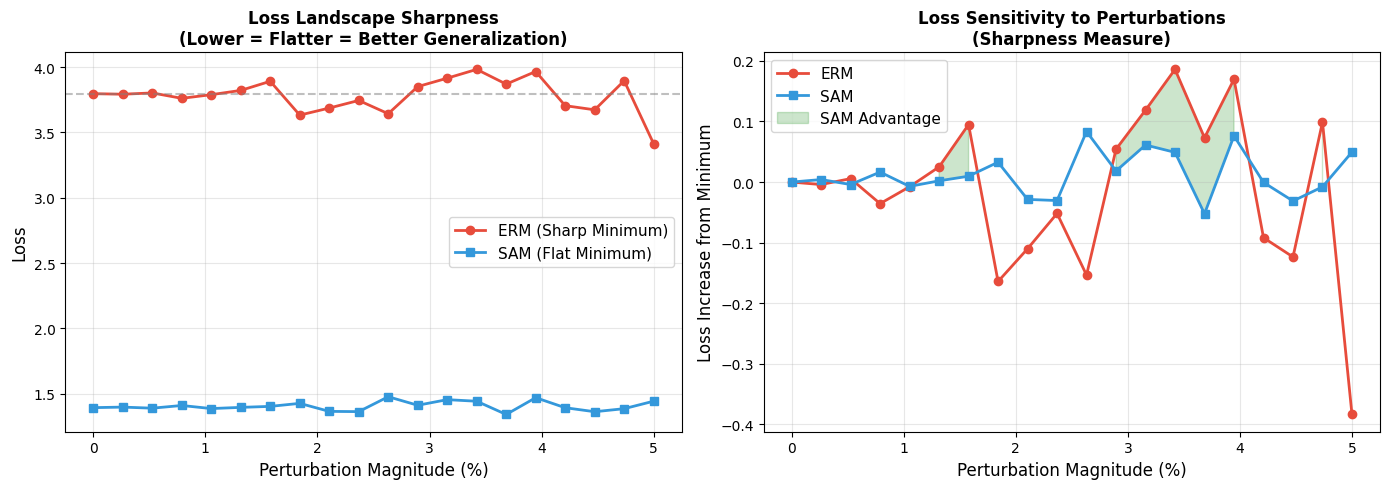


   Sharpness Reduction: 55.1%
   ✓ SAM achieved significantly flatter minimum!

4️⃣ CONNECTING TO DOMAIN GENERALIZATION THEORY:
--------------------------------------------------------------------------------
   Why flat minima help with domain shift:

   • Sharp minimum: Loss increases rapidly with parameter perturbations
     → Model is sensitive to small changes in data distribution
     → Domain shift acts like a 'perturbation' to the learned features
     → Sharp models fail to generalize OOD

   • Flat minimum: Loss stays low in a neighborhood of parameters
     → Model is robust to small distribution changes
     → Features work across a wider range of data variations
     → Flat models generalize better to new domains

   SAM explicitly optimizes: L_SAM(θ) = max_{||ε||≤ρ} L(θ + ε)
   This is a form of ROBUST OPTIMIZATION similar to:
     • DRO: Optimizes worst-case domain
     • SAM: Optimizes worst-case parameter perturbation

5️⃣ FLATNESS AS IMPLICIT REGULARIZATION:
--------

In [ ]:
sharpness_analysis = analyze_sam_performance(
    sam_results=sam_results,
    erm_source_accs=erm_source_accs,
    erm_target_acc=erm_target_acc,
    sam_model=sam_model,
    erm_model=erm_model,
    test_loader=target_test_loader, 
    device=device
)



In [ ]:
torch.save(sam_model.state_dict(), "sam_model.pth")
print("Saved model: sam_model.pth")

Saved model: sam_model.pth


---

Reload SAM

In [ ]:
def create_model():
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
    num_classes = len(art_dataset.classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

sam_model = create_model()
sam_model.load_state_dict(torch.load("sam_model.pth", map_location=device))
sam_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in target_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = sam_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

target_acc = 100 * correct / total
print(f"SAM Target (Sketch) Accuracy: {target_acc:.2f}% ({correct}/{total})")

SAM Target (Sketch) Accuracy: 65.56% (2576/3929)


---

ABLATIVE STUDY on RHO (SAM)

In [ ]:
# SAM Ablation Study: Different Rho Values


rho_values = [0.01, 0.05, 0.1, 0.2]  
all_results = []  



for rho in rho_values:
    print(f"\nRunning SAM with rho = {rho}")
    print("-" * 80)


    sam_model = create_model()


    sam_optimizer = SAM(
        sam_model.parameters(),
        base_optimizer=optim.Adam,
        rho=rho,
        lr=1e-4,
        weight_decay=1e-4
    )


    sam_results = train_sam_model(
        model=sam_model,
        source_loaders=source_train_loaders,
        optimizer=sam_optimizer,
        epochs=10,
        device=device
    )

    sam_results['rho'] = rho
    all_results.append(sam_results)



STARTING SAM ABLATION STUDY

Running SAM with rho = 0.01
--------------------------------------------------------------------------------
---Training with SAM (Sharpness-Aware Minimization)---
   Perturbation radius (ρ): 0.01
   This finds flat minima resistant to domain shifts


SAM Epoch 5/10: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, loss=0.00821]



📊 SAM Epoch 5 Results:
   art_painting: 91.22%
   cartoon: 96.16%
   photo: 98.20%
   Average Source: 95.20%
   Target (sketch): 61.06%
   Loss: 0.0082


SAM Epoch 10/10: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s, loss=0.00197]



📊 SAM Epoch 10 Results:
   art_painting: 91.46%
   cartoon: 95.95%
   photo: 98.80%
   Average Source: 95.40%
   Target (sketch): 62.92%
   Loss: 0.0020

Running SAM with rho = 0.05
--------------------------------------------------------------------------------
---Training with SAM (Sharpness-Aware Minimization)---
   Perturbation radius (ρ): 0.05
   This finds flat minima resistant to domain shifts


SAM Epoch 5/10: 100%|██████████| 41/41 [00:27<00:00,  1.48it/s, loss=0.0122]



📊 SAM Epoch 5 Results:
   art_painting: 91.22%
   cartoon: 95.95%
   photo: 99.10%
   Average Source: 95.42%
   Target (sketch): 68.29%
   Loss: 0.0122


SAM Epoch 10/10: 100%|██████████| 41/41 [00:27<00:00,  1.46it/s, loss=0.00307]



📊 SAM Epoch 10 Results:
   art_painting: 92.68%
   cartoon: 95.74%
   photo: 98.20%
   Average Source: 95.54%
   Target (sketch): 66.71%
   Loss: 0.0031

Running SAM with rho = 0.1
--------------------------------------------------------------------------------
---Training with SAM (Sharpness-Aware Minimization)---
   Perturbation radius (ρ): 0.1
   This finds flat minima resistant to domain shifts


SAM Epoch 5/10: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, loss=0.0215]



📊 SAM Epoch 5 Results:
   art_painting: 91.71%
   cartoon: 95.74%
   photo: 98.80%
   Average Source: 95.42%
   Target (sketch): 66.89%
   Loss: 0.0215


SAM Epoch 10/10: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, loss=0.00401]



📊 SAM Epoch 10 Results:
   art_painting: 93.41%
   cartoon: 97.23%
   photo: 98.20%
   Average Source: 96.28%
   Target (sketch): 67.75%
   Loss: 0.0040

Running SAM with rho = 0.2
--------------------------------------------------------------------------------
---Training with SAM (Sharpness-Aware Minimization)---
   Perturbation radius (ρ): 0.2
   This finds flat minima resistant to domain shifts


SAM Epoch 5/10: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, loss=0.0519]



📊 SAM Epoch 5 Results:
   art_painting: 91.46%
   cartoon: 95.74%
   photo: 97.60%
   Average Source: 94.93%
   Target (sketch): 70.35%
   Loss: 0.0519


SAM Epoch 10/10: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s, loss=0.0114]



📊 SAM Epoch 10 Results:
   art_painting: 91.71%
   cartoon: 97.23%
   photo: 97.90%
   Average Source: 95.61%
   Target (sketch): 69.18%
   Loss: 0.0114


In [ ]:
print(f"{'ρ':<10}{'Final Source Avg (%)':<25}{'Target Acc (%)':<20}")
print("-" * 60)

for res in all_results:
    source_avg = sum(res['final_source_accs']) / len(res['final_source_accs'])
    target_acc = res['final_target_acc']
    print(f"{res['rho']:<10}{source_avg:<25.2f}{target_acc:<20.2f}")


SAM ABLATION RESULTS (Varying Rho)
ρ         Final Source Avg (%)     Target Acc (%)      
------------------------------------------------------------
0.01      95.40                    62.92               
0.05      95.54                    66.71               
0.1       96.28                    67.75               
0.2       95.61                    69.18               


EXTENSION: larger rho values

In [ ]:
rho_values = [0.5, 1.0]
all_results = []  

for rho in rho_values:
    print(f"\nRunning SAM with rho = {rho}")
    print("-" * 80)


    sam_model = create_model()


    sam_optimizer = SAM(
        sam_model.parameters(),
        base_optimizer=optim.Adam,
        rho=rho,
        lr=1e-4,
        weight_decay=1e-4
    )


    sam_results = train_sam_model(
        model=sam_model,
        source_loaders=source_train_loaders,
        optimizer=sam_optimizer,
        epochs=10,
        device=device
    )

    sam_results['rho'] = rho
    all_results.append(sam_results)



STARTING SAM ABLATION STUDY

Running SAM with rho = 0.5
--------------------------------------------------------------------------------
---Training with SAM (Sharpness-Aware Minimization)---
   Perturbation radius (ρ): 0.5
   This finds flat minima resistant to domain shifts


SAM Epoch 5/10: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, loss=0.215]



📊 SAM Epoch 5 Results:
   art_painting: 91.46%
   cartoon: 92.96%
   photo: 97.01%
   Average Source: 93.81%
   Target (sketch): 65.41%
   Loss: 0.2153


SAM Epoch 10/10: 100%|██████████| 41/41 [00:27<00:00,  1.47it/s, loss=0.0922]



📊 SAM Epoch 10 Results:
   art_painting: 91.71%
   cartoon: 94.46%
   photo: 97.60%
   Average Source: 94.59%
   Target (sketch): 65.84%
   Loss: 0.0922

Running SAM with rho = 1.0
--------------------------------------------------------------------------------
---Training with SAM (Sharpness-Aware Minimization)---
   Perturbation radius (ρ): 1.0
   This finds flat minima resistant to domain shifts


SAM Epoch 5/10: 100%|██████████| 41/41 [00:28<00:00,  1.46it/s, loss=1.5]



📊 SAM Epoch 5 Results:
   art_painting: 30.00%
   cartoon: 29.85%
   photo: 52.10%
   Average Source: 37.32%
   Target (sketch): 19.67%
   Loss: 1.5030


SAM Epoch 10/10: 100%|██████████| 41/41 [00:31<00:00,  1.29it/s, loss=1.51]



📊 SAM Epoch 10 Results:
   art_painting: 39.51%
   cartoon: 45.84%
   photo: 73.05%
   Average Source: 52.80%
   Target (sketch): 19.55%
   Loss: 1.5059


In [ ]:
print(f"{'ρ':<10}{'Final Source Avg (%)':<25}{'Target Acc (%)':<20}")
print("-" * 60)

for res in all_results:
    source_avg = sum(res['final_source_accs']) / len(res['final_source_accs'])
    target_acc = res['final_target_acc']
    print(f"{res['rho']:<10}{source_avg:<25.2f}{target_acc:<20.2f}")


SAM ABLATION RESULTS (Varying Rho)
ρ         Final Source Avg (%)     Target Acc (%)      
------------------------------------------------------------
0.5       94.59                    65.84               
1.0       52.80                    19.55               


---
Ablative Study (IRM)

In [ ]:
class IRMv1Loss_SquaredNorm(nn.Module):
    
    def __init__(self, penalty_weight=1.0):
        super().__init__()
        self.penalty_weight = penalty_weight

    def forward(self, logits_list, labels_list):
        
        device = logits_list[0].device
        nll = 0.0
        penalty = 0.0

        for logits, labels in zip(logits_list, labels_list):
            loss_e = nn.functional.cross_entropy(logits, labels)
            nll += loss_e

            scale = torch.ones(1, requires_grad=True, device=device)

            scaled_loss = nn.functional.cross_entropy(logits * scale, labels)

            grad_scale = grad(scaled_loss, scale, create_graph=True)[0]

            penalty += grad_scale.pow(2).sum()

        nll = nll / len(logits_list)
        total_loss = nll + self.penalty_weight * penalty

        return total_loss, nll, penalty


class IRMv1Loss_Variance(nn.Module):
    
    def __init__(self, penalty_weight=1.0):
        super().__init__()
        self.penalty_weight = penalty_weight

    def forward(self, logits_list, labels_list):
        
        device = logits_list[0].device
        nll = 0.0
        grad_norms = []

        for logits, labels in zip(logits_list, labels_list):
            loss_e = nn.functional.cross_entropy(logits, labels)
            nll += loss_e

            scale = torch.ones(1, requires_grad=True, device=device)
            scaled_loss = nn.functional.cross_entropy(logits * scale, labels)
            grad_scale = grad(scaled_loss, scale, create_graph=True)[0]

            grad_norms.append(grad_scale.pow(2).sum())

        nll = nll / len(logits_list)

        if len(grad_norms) > 1:
            grad_norms_tensor = torch.stack(grad_norms)
            penalty = torch.var(grad_norms_tensor, unbiased=False)
        else:
            penalty = torch.tensor(0.0, device=device)

        total_loss = nll + self.penalty_weight * penalty

        return total_loss, nll, penalty

# =============================================================================

def train_irm_model(model, source_loaders, criterion, optimizer, epochs=10):
    
    model.train()
    train_losses = []
    nll_losses = []
    penalties = []

    variant_name = "Variance" if "Variance" in criterion.__class__.__name__ else "SquaredNorm"
    print(f"\n🚀 Training IRM ({variant_name}, λ={criterion.penalty_weight})...")

    iterators = {}
    for domain in source_domains:
        def make_infinite(loader):
            while True:
                for batch in loader:
                    yield batch
        iterators[domain] = make_infinite(source_loaders[domain])

    steps_per_epoch = min(len(loader) for loader in source_loaders.values())

    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        epoch_nll = 0.0
        epoch_penalty = 0.0

        loop = tqdm(range(steps_per_epoch), desc=f"IRM Epoch {epoch}/{epochs}")

        for step in loop:
            logits_list = []
            labels_list = []

            for domain in source_domains:
                imgs, labels = next(iterators[domain])
                imgs, labels = imgs.to(device), labels.to(device)

                logits = model(imgs)
                logits_list.append(logits)
                labels_list.append(labels)

            total_loss, nll, penalty = criterion(logits_list, labels_list)

            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += total_loss.item()
            epoch_nll += nll.item()
            epoch_penalty += penalty.item()

            loop.set_postfix(
                loss=epoch_loss/(step+1),
                nll=epoch_nll/(step+1),
                penalty=epoch_penalty/(step+1)
            )

        avg_loss = epoch_loss / steps_per_epoch
        avg_nll = epoch_nll / steps_per_epoch
        avg_penalty = epoch_penalty / steps_per_epoch

        train_losses.append(avg_loss)
        nll_losses.append(avg_nll)
        penalties.append(avg_penalty)

        if epoch == epochs:
            print(f"\n IRM Epoch {epoch} Results:")
            source_accs = []
            for domain in source_domains:
                acc = evaluate_model(model, source_test_loaders[domain])
                source_accs.append(acc)
                print(f"   {domain}: {acc:.2f}%")

            target_acc = evaluate_model(model, target_test_loader)
            avg_source_acc = np.mean(source_accs)
            print(f"   Average Source: {avg_source_acc:.2f}%")
            print(f"   Target ({target_domain}): {target_acc:.2f}%")
            print(f"   Final NLL: {avg_nll:.4f}, Penalty: {avg_penalty:.4f}")

    return train_losses, nll_losses, penalties


# =========================================

def run_irm_ablation(penalty_weights=[0.1, 1.0, 10.0], use_variance=True):
    
    print("\n" + "="*80)
    print(f"IRM ABLATION STUDY: {'Variance' if use_variance else 'SquaredNorm'} Version")
    print("="*80)

    results = []

    for pw in penalty_weights:
        print(f"\n{'='*80}")
        print(f"Testing λ = {pw}")
        print(f"{'='*80}")

        model = create_model()

        if use_variance:
            criterion = IRMv1Loss_Variance(penalty_weight=pw)
        else:
            criterion = IRMv1Loss_SquaredNorm(penalty_weight=pw)

        optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

        losses, nlls, penalties = train_irm_model(
            model, source_train_loaders, criterion, optimizer, epochs=10
        )

        source_accs = []
        for domain in source_domains:
            acc = evaluate_model(model, source_test_loaders[domain])
            source_accs.append(acc)

        target_acc = evaluate_model(model, target_test_loader)
        avg_source = np.mean(source_accs)

        if pw == 1.0:
          torch.save(model.state_dict(), 'irm_model_1.pth')
          print("---losses---")
          print(losses)
          print("---nlls---")
          print(nlls)
          print("---penalties---")
          print(penalties)


        results.append({
            'penalty_weight': pw,
            'avg_source_acc': avg_source,
            'target_acc': target_acc,
            'final_penalty': penalties[-1],
            'final_nll': nlls[-1]
        })

    print("\n" + "="*80)
    print("RESULTS SUMMARY")
    print("="*80)
    print(f"{'λ':>6} {'Avg Source':>12} {'Target':>8} {'Penalty':>10} {'NLL':>8}")
    print("-"*80)
    for r in results:
        print(f"{r['penalty_weight']:>6.1f} {r['avg_source_acc']:>12.2f}% "
              f"{r['target_acc']:>8.2f}% {r['final_penalty']:>10.4f} "
              f"{r['final_nll']:>8.4f}")
    print("="*80)

    return results



In [ ]:
print("\n" + " Running Variance-based IRM)")
variance_results = run_irm_ablation(
    penalty_weights=[0.1, 1.0, 10.0, 100.0],
    use_variance=True
)



🎯 Running Variance-based IRM (Recommended)

IRM ABLATION STUDY: Variance Version

Testing λ = 0.1

🚀 Training IRM (Variance, λ=0.1)...


IRM Epoch 10/10: 100%|██████████| 41/41 [00:16<00:00,  2.51it/s, loss=0.0057, nll=0.0057, penalty=1.04e-5]



📊 IRM Epoch 10 Results:
   art_painting: 90.98%
   cartoon: 91.04%
   photo: 98.20%
   Average Source: 93.41%
   Target (sketch): 61.36%
   Final NLL: 0.0057, Penalty: 0.0000

Testing λ = 1.0

🚀 Training IRM (Variance, λ=1.0)...


IRM Epoch 10/10: 100%|██████████| 41/41 [00:16<00:00,  2.50it/s, loss=0.00329, nll=0.00328, penalty=5.67e-8]



📊 IRM Epoch 10 Results:
   art_painting: 91.22%
   cartoon: 90.62%
   photo: 97.90%
   Average Source: 93.25%
   Target (sketch): 67.32%
   Final NLL: 0.0033, Penalty: 0.0000

Testing λ = 10.0

🚀 Training IRM (Variance, λ=10.0)...


IRM Epoch 10/10: 100%|██████████| 41/41 [00:16<00:00,  2.49it/s, loss=0.0036, nll=0.0036, penalty=7.58e-8]



📊 IRM Epoch 10 Results:
   art_painting: 90.49%
   cartoon: 89.34%
   photo: 97.31%
   Average Source: 92.38%
   Target (sketch): 65.72%
   Final NLL: 0.0036, Penalty: 0.0000

Testing λ = 100.0

🚀 Training IRM (Variance, λ=100.0)...


IRM Epoch 10/10: 100%|██████████| 41/41 [00:16<00:00,  2.47it/s, loss=0.00417, nll=0.00415, penalty=1.37e-7]



📊 IRM Epoch 10 Results:
   art_painting: 89.27%
   cartoon: 91.04%
   photo: 97.90%
   Average Source: 92.74%
   Target (sketch): 64.19%
   Final NLL: 0.0042, Penalty: 0.0000

ABLATION RESULTS SUMMARY
     λ   Avg Source   Target    Penalty      NLL
--------------------------------------------------------------------------------


KeyError: 'nll_loss'

SquaredNorm-based IRM

In [ ]:

print("\n" + "Running SquaredNorm-based IRM (Original Paper)")
squared_results = run_irm_ablation(
    penalty_weights=[0.1, 1.0, 10.0, 100.0],
    use_variance=False
)


📊 Running SquaredNorm-based IRM (Original Paper)

IRM ABLATION STUDY: SquaredNorm Version

Testing λ = 0.1

🚀 Training IRM (SquaredNorm, λ=0.1)...


IRM Epoch 10/10: 100%|██████████| 41/41 [00:16<00:00,  2.54it/s, loss=0.0025, nll=0.00243, penalty=0.000628]



📊 IRM Epoch 10 Results:
   art_painting: 91.22%
   cartoon: 91.04%
   photo: 98.20%
   Average Source: 93.49%
   Target (sketch): 64.47%
   Final NLL: 0.0024, Penalty: 0.0006

Testing λ = 1.0

🚀 Training IRM (SquaredNorm, λ=1.0)...


IRM Epoch 10/10: 100%|██████████| 41/41 [00:16<00:00,  2.52it/s, loss=0.00249, nll=0.00207, penalty=0.000412]



📊 IRM Epoch 10 Results:
   art_painting: 88.78%
   cartoon: 92.75%
   photo: 98.20%
   Average Source: 93.24%
   Target (sketch): 62.81%
   Final NLL: 0.0021, Penalty: 0.0004

Testing λ = 10.0

🚀 Training IRM (SquaredNorm, λ=10.0)...


IRM Epoch 10/10: 100%|██████████| 41/41 [00:16<00:00,  2.49it/s, loss=0.903, nll=0.476, penalty=0.0427]



📊 IRM Epoch 10 Results:
   art_painting: 75.37%
   cartoon: 74.84%
   photo: 87.43%
   Average Source: 79.21%
   Target (sketch): 54.21%
   Final NLL: 0.4756, Penalty: 0.0427

Testing λ = 100.0

🚀 Training IRM (SquaredNorm, λ=100.0)...


IRM Epoch 10/10: 100%|██████████| 41/41 [00:16<00:00,  2.51it/s, loss=2.81, nll=1.65, penalty=0.0116]



📊 IRM Epoch 10 Results:
   art_painting: 22.44%
   cartoon: 22.39%
   photo: 25.45%
   Average Source: 23.43%
   Target (sketch): 23.72%
   Final NLL: 1.6523, Penalty: 0.0116

ABLATION RESULTS SUMMARY
     λ   Avg Source   Target    Penalty      NLL
--------------------------------------------------------------------------------


KeyError: 'nll_loss'

Results not computed in tables but shown in logs for these ablations studies

# END

---